In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 3.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633974 sha256=5ce76fe9dcfd11f6da99abefe6b41adb259b332dca5737e372962779d7888920
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import math
import random
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split 
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from surprise import Reader, Dataset
from surprise.model_selection import  GridSearchCV as GCVSurprise
from surprise.prediction_algorithms import SVD, BaselineOnly, KNNBaseline, SVDpp
reader = Reader(rating_scale=(1,5))


In [ ]:
!gdown --id 12MtMw12Ty5ZJ17pr1zyfs3cY6yhrG2A1

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=12MtMw12Ty5ZJ17pr1zyfs3cY6yhrG2A1
To: /content/archive.zip
100% 560M/560M [00:04<00:00, 132MB/s]


In [ ]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: SampleSubmission (1).csv  
  inflating: VariableDefinitions.txt  
  inflating: orders.csv              
  inflating: test_customers.csv      
  inflating: test_full.csv           
  inflating: test_locations.csv      
  inflating: train_customers.csv     
  inflating: train_full.csv          
  inflating: train_locations.csv     
  inflating: vendors.csv             


#1. EDA

## Checking location data

### Vendors location

In [ ]:
vendors = pd.read_csv('vendors.csv')
vendors.head()

id  authentication_id  latitude  longitude vendor_category_en  \
0   4           118597.0 -0.588596   0.754434        Restaurants   
1  13           118608.0 -0.471654   0.744470        Restaurants   
2  20           118616.0 -0.407527   0.643681        Restaurants   
3  23           118619.0 -0.585385   0.753811        Restaurants   
4  28           118624.0  0.480602   0.552850        Restaurants   

   vendor_category_id  delivery_charge  serving_distance  is_open  \
0                 2.0              0.0               6.0      1.0   
1                 2.0              0.7               5.0      1.0   
2                 2.0              0.0               8.0      1.0   
3                 2.0              0.0               5.0      1.0   
4                 2.0              0.7              15.0      1.0   

       OpeningTime  ... open_close_flags                 vendor_tag  \
0  11:00AM-11:30PM  ...              1.0  2,4,5,8,91,22,12,24,16,23   
1  08:30AM-10:30PM  ...              1.0  4,41,51,34,27,15,24,16,28   
2  08:00AM-10:45PM  ...              1.0                  4,8,91,10   
3  10:59AM-10:30PM  ...              1.0                  5,8,30,24   
4  11:00AM-11:45PM  ...              1.0                          5   

                                     vendor_tag_name one_click_vendor  \
0  Arabic,Breakfast,Burgers,Desserts,Free Deliver...                Y   
1  Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...                Y   
2            Breakfast,Desserts,Free Delivery,Indian                Y   
3                      Burgers,Desserts,Fries,Salads                Y   
4                                            Burgers                Y   

   country_id  city_id           created_at           updated_at device_type  \
0         1.0      1.0  2018-01-30 14:42:04  2020-04-07 15:12:43           3   
1         1.0      1.0  2018-05-03 12:32:06  2020-04-05 20:46:03           3   
2         1.0      1.0  2018-05-04 22:28:22  2020-04-07 16:35:55           3   
3         1.0      1.0  2018-05-06 19:20:48  2020-04-02 00:56:17           3   
4         1.0      1.0  2018-05-17 22:12:38  2020-04-05 15:57:41           3   

   display_orders  
0               1  
1               1  
2               1  
3               1  
4               1  

[5 rows x 59 columns]

In [ ]:
fig = px.scatter_geo(vendors,lat='latitude',lon='longitude', hover_name="id")
fig.update_layout(title = 'Vendors_locations', title_x=0.5)
fig.show()

### Train data locations

In [ ]:
train_locations = pd.read_csv('train_locations.csv')
train_locations.head()

customer_id  location_number location_type  latitude  longitude
0     02SFNJH                0           NaN  1.682392 -78.789737
1     02SFNJH                1           NaN  1.679137   0.766823
2     02SFNJH                2           NaN -0.498648   0.661241
3     RU43CXC                0          Home  0.100853   0.438165
4     BDFBPRD                0           NaN  2.523125   0.733464

In [ ]:
#checking train_location info
train_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59503 entries, 0 to 59502
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      59503 non-null  object 
 1   location_number  59503 non-null  int64  
 2   location_type    32294 non-null  object 
 3   latitude         59497 non-null  float64
 4   longitude        59497 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.3+ MB


In [ ]:
print('null values in the location type column is',str(1 - (32294/59502))+'%')

null values in the location type column is 0.45726194077509996%


In [ ]:
#checking location_number vs location_type
(train_locations[~train_locations.location_type.isna()]['location_number'].astype('str')+'-'+train_locations[~train_locations.location_type.isna()]['location_type']).value_counts()

0-Home      12288
1-Home       4229
0-Work       3952
0-Other      3922
2-Home       1617
            ...  
13-Work         1
11-Work         1
16-Other        1
16-Work         1
29-Home         1
Length: 62, dtype: int64

There is no relation bw location number and location type. location_type could have been a useful column if we had some order history of our test customers. but as it is a cold start problem (i.e. we dont have any history of test customers) this feature is not very useful. So dropping it.

In [ ]:
train_locations = train_locations.drop(['location_type'],axis=1)

In [ ]:
#visualising train locations
fig = px.scatter_geo(train_locations,lat='latitude',lon='longitude', hover_name="customer_id")
fig.update_layout(title = 'train_customers_locations', title_x=0.5)
fig.show()

### Checking the distance bw customers and vendors

In [ ]:
#defining function to mesaure distance bw 2 locations
#ref - https://www.adamsmith.haus/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python
#radius of the Earth
def distance(df):
  R = 6373.0


  #coordinates
  lat1 = df.latitude_x.apply(math.radians)
  lon1 = df.longitude_x.apply(math.radians)
  lat2 = df.latitude_y.apply(math.radians)
  lon2 = df.longitude_y.apply(math.radians)

  #change in coordinates
  dlon = lon2 - lon1


  dlat = lat2 - lat1

  #Haversine formula
  a = ((dlat / 2)**2).apply(math.sin) + (lat1).apply(math.cos) * (lat2).apply(math.cos) * ((dlon / 2)**2).apply(math.sin)

  c = 2 * (a.apply(np.sqrt)/(1 - a).apply(np.sqrt)).apply(math.atan)
  distance = R * c
  return distance

In [ ]:
train_location = train_locations[['latitude','longitude']]
train_location['type'] = 'customers'
vendor_location = vendors[['latitude','longitude']]
vendor_location['type'] = 'vendors'
locations = train_location.append(vendor_location)
fig = px.scatter_geo(locations,lat='latitude',lon='longitude', color="type")
fig.update_layout(title = 'locations', title_x=0.5)
fig.show()

For MF we need to merge train_fill.csv and orders.csv on 'CID X LOC_NUM X VENDOR'

In [ ]:
train_full = pd.read_csv('/content/train_full.csv')
train_orders = pd.read_csv('/content/orders.csv')
train = train_full.merge(train_orders,on='CID X LOC_NUM X VENDOR',how='inner')

In [ ]:
distance = distance(train)

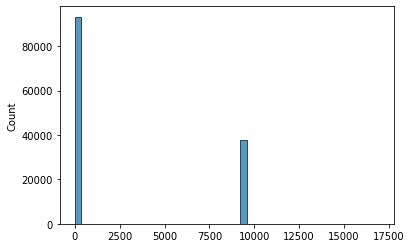

In [ ]:
sns.histplot(distance)

In [ ]:
print('the maximum distance a vendor deliver is',str(np.max(train.serving_distance)))
percentiles = [5,10,11,12,15,20,30,50,75,100]
for i in percentiles:
  print(str(i)+' th percentile is', str(np.nanpercentile(distance,i)))

the maximum distance a vendor deliver is 15.0
5 th percentile is 8.663748299284842
10 th percentile is 14.564115659929197
11 th percentile is 15.850760176954099
12 th percentile is 17.047497503270332
15 th percentile is 20.631679268718077
20 th percentile is 27.21809194547721
30 th percentile is 42.568634952755836
50 th percentile is 80.56796484059669
75 th percentile is 9416.895226571361
100 th percentile is 16958.836767817513


as 90% of location data are not showing the correct distance we can't trust location data. So we are removing the location data

## sdfs

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132027 entries, 0 to 132026
Data columns (total 98 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   customer_id_x                   132027 non-null  object 
 1   gender                          104549 non-null  object 
 2   status_x                        132027 non-null  int64  
 3   verified_x                      132027 non-null  int64  
 4   created_at_x                    132027 non-null  object 
 5   updated_at_x                    132027 non-null  object 
 6   location_number                 132027 non-null  int64  
 7   location_type                   63113 non-null   object 
 8   latitude_x                      132022 non-null  float64
 9   longitude_x                     132022 non-null  float64
 10  id                              132027 non-null  int64  
 11  authentication_id               132027 non-null  float64
 12  latitude_y      

In [ ]:
train_customers = pd.read_csv('train_customers.csv')
train_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34674 entries, 0 to 34673
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   akeed_customer_id  34674 non-null  object 
 1   gender             22520 non-null  object 
 2   dob                3046 non-null   float64
 3   status             34674 non-null  int64  
 4   verified           34674 non-null  int64  
 5   language           21099 non-null  object 
 6   created_at         34674 non-null  object 
 7   updated_at         34674 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.1+ MB


### Date columns

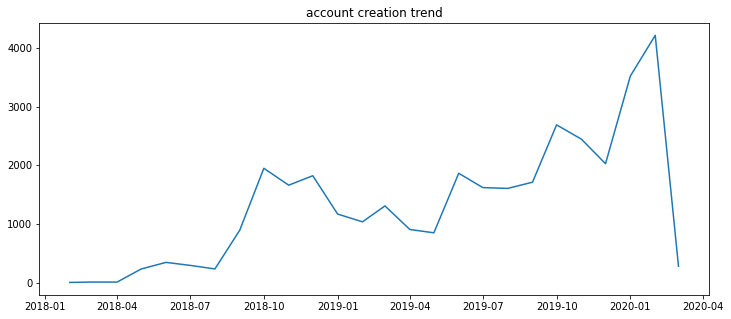

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(pd.DataFrame(pd.to_datetime(train_customers['created_at'].apply(lambda x:x[:7]+'-01')).value_counts()).sort_index())
plt.title('account creation trend')
plt.show()

In [ ]:
np.sum(pd.to_datetime(train_customers['created_at'].apply(lambda x: x[:10])).dt.to_period('M')<'2019-09-01')/train_customers.shape[0]*100

51.31222241448924

Using '2019-09-01' as the partition. Users who have created account before '2019-09-01' are old customers and others are new customers. We will use it in CF to find similarity bw users

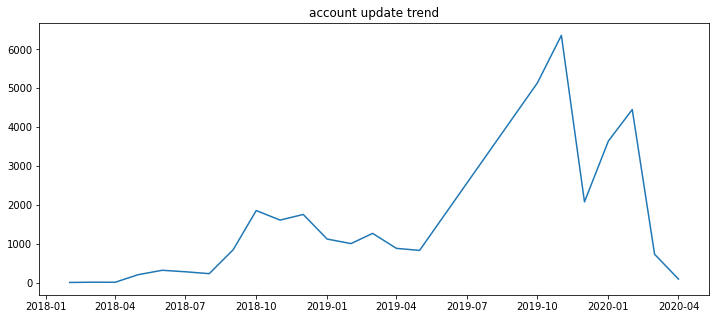

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(pd.DataFrame(pd.to_datetime(train_customers['updated_at'].apply(lambda x:x[:7]+'-01')).value_counts()).sort_index())
plt.title('account update trend')
plt.show()

In [ ]:
np.sum(pd.to_datetime(train_customers['updated_at'].apply(lambda x: x[:10])).dt.to_period('M')<'2019-11-01')/train_customers.shape[0]*100

49.96827594162773

Using '2019-11-01' as the partition. Users who have updated account after '2019-11-01' are updated customers and others are not. We will use it in CF to find similarity bw users

In [ ]:
train_customers.verified.value_counts(normalize=True)

1    0.956538
0    0.043462
Name: verified, dtype: float64

removing verified feature as it is highly skewed

In [ ]:
train_customers.language.value_counts(normalize=True)

EN    1.0
Name: language, dtype: float64

removing language column as it has only one value

In [ ]:
train_customers.gender.apply(lambda x: str(x).lower()[:1]).value_counts(normalize=True)

m    0.598085
n    0.350522
f    0.051306
?    0.000058
     0.000029
Name: gender, dtype: float64

almost 60% customers are male. So we will create new column is_male

In [ ]:
train_customers.status.value_counts(normalize=True)

1    0.998991
0    0.001009
Name: status, dtype: float64

DOB

In [ ]:
print('null values in DOB column is', str((1 -3046/34674)*100)+'%')

null values in DOB column is 91.2153198361885%


This column is not useful. we need to remove it

### Let's look at train location and test location

In [ ]:
test_locations = pd.read_csv('test_locations.csv')

In [ ]:
train_locations['type'] = 'train'
test_locations['type'] = 'test'
locations = train_locations.append(test_locations)

In [ ]:
locations

customer_id  location_number  latitude  longitude   type location_type
0         02SFNJH                0  1.682392 -78.789737  train           NaN
1         02SFNJH                1  1.679137   0.766823  train           NaN
2         02SFNJH                2 -0.498648   0.661241  train           NaN
3         RU43CXC                0  0.100853   0.438165  train           NaN
4         BDFBPRD                0  2.523125   0.733464  train           NaN
...           ...              ...       ...        ...    ...           ...
16715     L9G4OFV                4 -0.197722   0.609199   test           NaN
16716     L9G4OFV                5 -0.343042   0.626064   test           NaN
16717     FDZFYBA                0 -0.974907  -0.177863   test          Home
16718     UTKHR1C                0  1.058539   0.001628   test         Other
16719     3O8LSR3                0 -0.188562   0.827181   test         Other

[76223 rows x 6 columns]

In [ ]:
#visualising train locations
fig = px.scatter_geo(locations,lat='latitude',lon='longitude', color="type")
fig.update_layout(title = 'locations', title_x=0.5)
fig.show()

train and test locations almost overlap to each other. we can use the location data to find similerities bw users

## Now for vendor vendor similarities

In [ ]:
vendors = pd.read_csv('vendors.csv')
vendors.head()

id  authentication_id  latitude  longitude vendor_category_en  \
0   4           118597.0 -0.588596   0.754434        Restaurants   
1  13           118608.0 -0.471654   0.744470        Restaurants   
2  20           118616.0 -0.407527   0.643681        Restaurants   
3  23           118619.0 -0.585385   0.753811        Restaurants   
4  28           118624.0  0.480602   0.552850        Restaurants   

   vendor_category_id  delivery_charge  serving_distance  is_open  \
0                 2.0              0.0               6.0      1.0   
1                 2.0              0.7               5.0      1.0   
2                 2.0              0.0               8.0      1.0   
3                 2.0              0.0               5.0      1.0   
4                 2.0              0.7              15.0      1.0   

       OpeningTime  ... open_close_flags                 vendor_tag  \
0  11:00AM-11:30PM  ...              1.0  2,4,5,8,91,22,12,24,16,23   
1  08:30AM-10:30PM  ...              1.0  4,41,51,34,27,15,24,16,28   
2  08:00AM-10:45PM  ...              1.0                  4,8,91,10   
3  10:59AM-10:30PM  ...              1.0                  5,8,30,24   
4  11:00AM-11:45PM  ...              1.0                          5   

                                     vendor_tag_name one_click_vendor  \
0  Arabic,Breakfast,Burgers,Desserts,Free Deliver...                Y   
1  Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...                Y   
2            Breakfast,Desserts,Free Delivery,Indian                Y   
3                      Burgers,Desserts,Fries,Salads                Y   
4                                            Burgers                Y   

   country_id  city_id           created_at           updated_at device_type  \
0         1.0      1.0  2018-01-30 14:42:04  2020-04-07 15:12:43           3   
1         1.0      1.0  2018-05-03 12:32:06  2020-04-05 20:46:03           3   
2         1.0      1.0  2018-05-04 22:28:22  2020-04-07 16:35:55           3   
3         1.0      1.0  2018-05-06 19:20:48  2020-04-02 00:56:17           3   
4         1.0      1.0  2018-05-17 22:12:38  2020-04-05 15:57:41           3   

   display_orders  
0               1  
1               1  
2               1  
3               1  
4               1  

[5 rows x 59 columns]

In [ ]:
vendors.vendor_category_en.value_counts(normalize=True)

Restaurants       0.88
Sweets & Bakes    0.12
Name: vendor_category_en, dtype: float64

In [ ]:
vendors.vendor_category_id.value_counts(normalize=True)

2.0    0.89
3.0    0.11
Name: vendor_category_id, dtype: float64

In [ ]:
vendors  =vendors.drop(['vendor_category_en','vendor_category_id'],axis=1)

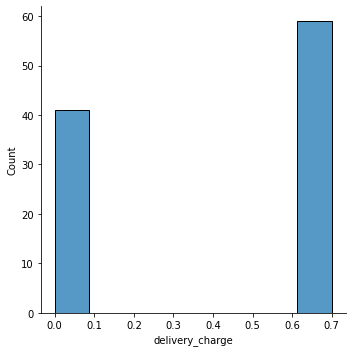

In [ ]:
sns.displot(vendors.delivery_charge)

In [ ]:
vendors.delivery_charge.value_counts()

0.7    59
0.0    41
Name: delivery_charge, dtype: int64

In [ ]:
train.delivery_charge.value_counts(normalize=True)

0.0    0.517167
0.7    0.482833
Name: delivery_charge, dtype: float64

In [ ]:
vendors.groupby('delivery_charge')['vendor_rating'].mean()

delivery_charge
0.0    4.336585
0.7    4.359322
Name: vendor_rating, dtype: float64

Even though more vendors take delivery charges but people preffer free deliveries. No effect of delivery charges on vendor ratings

columns like is_open, open time, open time 2 is not useful for this assignment, they would be useful for a live application

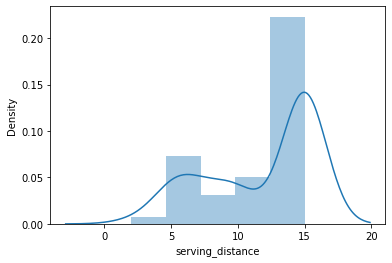

In [ ]:
sns.distplot(vendors.serving_distance)

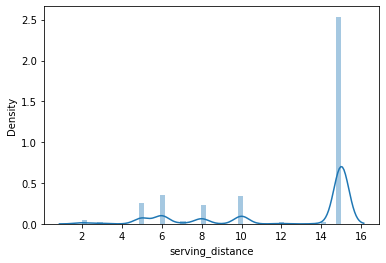

In [ ]:
sns.distplot(train.serving_distance)

the vendors which covers more distance for delivery has most of the orders

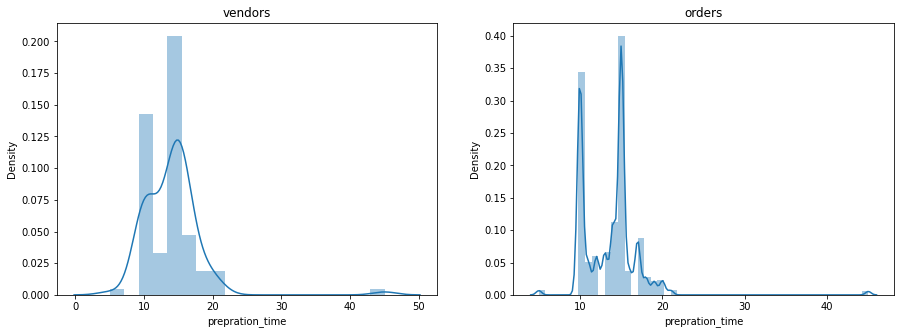

In [ ]:
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
sns.distplot(vendors.prepration_time)
plt.title('vendors')
plt.subplot(1,2,2)
sns.distplot(train.prepration_time)
plt.title('orders')
plt.show()

In [ ]:
vendors.prepration_time = (vendors.prepration_time - np.min(vendors.prepration_time))/(np.max(vendors.prepration_time) - np.min(vendors.prepration_time))

Most people preffer vendors who delivers within 10 - 20 mins

In [ ]:
vendors.commission.value_counts()

0.0    85
Name: commission, dtype: int64

In [ ]:
vendors.is_akeed_delivering.value_counts()

Yes    100
Name: is_akeed_delivering, dtype: int64

In [ ]:
vendors.discount_percentage.value_counts()

0.0     96
10.0     1
50.0     1
35.0     1
15.0     1
Name: discount_percentage, dtype: int64

In [ ]:
vendors.status.value_counts()

1.0    85
0.0    15
Name: status, dtype: int64

In [ ]:
vendors.verified.value_counts()

1    88
0    12
Name: verified, dtype: int64

In [ ]:
vendors['rank'].value_counts()

11    89
1     11
Name: rank, dtype: int64

In [ ]:
vendors.language.value_counts()

EN    85
Name: language, dtype: int64

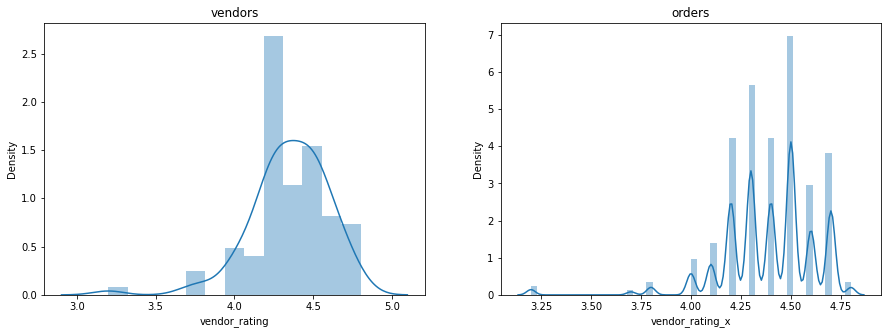

In [ ]:
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
sns.distplot(vendors.vendor_rating)
plt.title('vendors')
plt.subplot(1,2,2)
sns.distplot(train.vendor_rating_x)
plt.title('orders')
plt.show()

People preffer to order from high rated vendors

In [ ]:
vendors.primary_tags.value_counts()

{"primary_tags":"134"}     10
{"primary_tags":"2396"}     8
{"primary_tags":"8"}        5
{"primary_tags":"2072"}     3
{"primary_tags":"24"}       3
{"primary_tags":"32"}       3
{"primary_tags":"701"}      3
{"primary_tags":"1088"}     3
{"primary_tags":"46"}       3
{"primary_tags":"28"}       2
{"primary_tags":"90"}       2
{"primary_tags":"21"}       2
{"primary_tags":"1147"}     1
{"primary_tags":"815"}      1
{"primary_tags":"1348"}     1
{"primary_tags":"1065"}     1
{"primary_tags":"478"}      1
{"primary_tags":"1256"}     1
{"primary_tags":"260"}      1
{"primary_tags":"204"}      1
{"primary_tags":"180"}      1
{"primary_tags":"47"}       1
{"primary_tags":"15"}       1
{"primary_tags":"346"}      1
{"primary_tags":"849"}      1
{"primary_tags":"4"}        1
{"primary_tags":"52"}       1
{"primary_tags":"270"}      1
{"primary_tags":"7"}        1
{"primary_tags":"35"}       1
{"primary_tags":"297"}      1
{"primary_tags":"534"}      1
{"primary_tags":"138"}      1
{"primary_

In [ ]:
vendors.open_close_flags.value_counts()

1.0    100
Name: open_close_flags, dtype: int64

In [ ]:
vendors.vendor_tag_name = vendors.vendor_tag_name.fillna('0')

In [ ]:
categories_desc = []
for i in vendors.vendor_tag_name:
  a = i.split(',')
  for z in a:
    if z.lower().strip() not in categories_desc:
      categories_desc.append(z.lower().strip())

In [ ]:
a = np.zeros((100,68))
vendor_categories = pd.DataFrame(a,columns=categories_desc)
for i in range(100):
  for j in vendors.vendor_tag_name[i].split(','):
    vendor_categories.loc[i,j.lower().strip()] = 1
vendor_categories = vendor_categories.drop(['0'],axis=1)

In [ ]:
vendor_categories

arabic  breakfast  burgers  desserts  free delivery  grills  lebanese  \
0      1.0        1.0      1.0       1.0            1.0     1.0       1.0   
1      0.0        1.0      0.0       0.0            0.0     0.0       0.0   
2      0.0        1.0      0.0       1.0            1.0     0.0       0.0   
3      0.0        0.0      1.0       1.0            0.0     0.0       0.0   
4      0.0        0.0      1.0       0.0            0.0     0.0       0.0   
..     ...        ...      ...       ...            ...     ...       ...   
95     0.0        1.0      1.0       1.0            1.0     0.0       0.0   
96     0.0        0.0      1.0       1.0            1.0     0.0       0.0   
97     0.0        1.0      1.0       1.0            1.0     0.0       0.0   
98     0.0        1.0      1.0       1.0            1.0     0.0       0.0   
99     0.0        0.0      0.0       0.0            0.0     0.0       0.0   

    salads  sandwiches  shawarma  ...  bagels  churros  shuwa  frozen yoghurt  \
0      1.0         1.0       1.0  ...     0.0      0.0    0.0             0.0   
1      1.0         1.0       0.0  ...     0.0      0.0    0.0             0.0   
2      0.0         0.0       0.0  ...     0.0      0.0    0.0             0.0   
3      1.0         0.0       0.0  ...     0.0      0.0    0.0             0.0   
4      0.0         0.0       0.0  ...     0.0      0.0    0.0             0.0   
..     ...         ...       ...  ...     ...      ...    ...             ...   
95     1.0         0.0       0.0  ...     0.0      0.0    0.0             0.0   
96     1.0         0.0       0.0  ...     0.0      0.0    0.0             0.0   
97     1.0         0.0       0.0  ...     0.0      0.0    0.0             0.0   
98     1.0         0.0       0.0  ...     0.0      0.0    0.0             0.0   
99     0.0         1.0       0.0  ...     0.0      0.0    0.0             0.0   

    kushari  spanish latte  family meal  kebabs  cafe  fatayers  
0       0.0            0.0          0.0     0.0   0.0       0.0  
1       0.0            0.0          0.0     0.0   0.0       0.0  
2       0.0            0.0          0.0     0.0   0.0       0.0  
3       0.0            0.0          0.0     0.0   0.0       0.0  
4       0.0            0.0          0.0     0.0   0.0       0.0  
..      ...            ...          ...     ...   ...       ...  
95      0.0            0.0          0.0     0.0   1.0       0.0  
96      0.0            0.0          0.0     0.0   0.0       0.0  
97      0.0            0.0          0.0     0.0   1.0       0.0  
98      0.0            0.0          0.0     0.0   1.0       0.0  
99      0.0            0.0          0.0     0.0   0.0       1.0  

[100 rows x 67 columns]

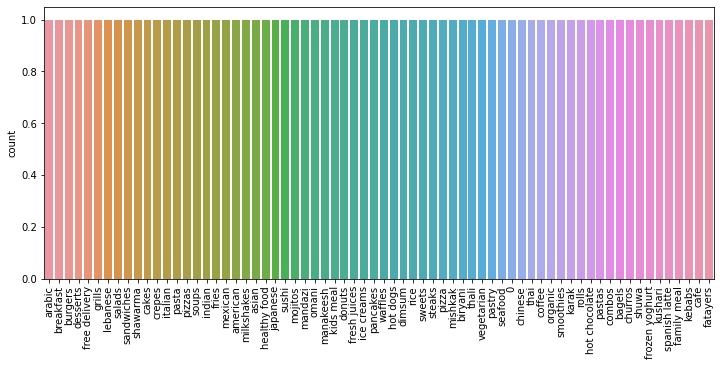

In [ ]:
#sns.countplot(vendor_categories.sum())
plt.figure(figsize=(12,5))
sns.countplot(categories_desc)
plt.xticks(rotation=90)
plt.show()

In [ ]:
train.vendor_tag_name = train.vendor_tag_name.fillna('0')
categories_desc_orders = []
for i in train.vendor_tag_name:
  a = i.split(',')
  for z in a:
    categories_desc_orders.append(z.lower().strip())

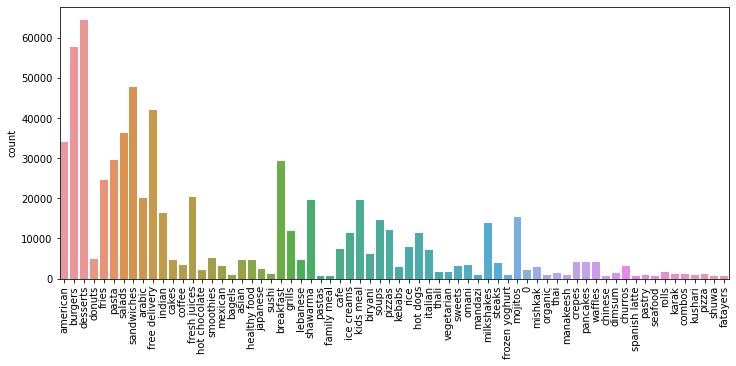

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(categories_desc_orders)
plt.xticks(rotation=90)
plt.show()

people prefer ordering dessert the most followed by burgers. Resturants are also serving foods according to demand. 

In [ ]:
vendors.one_click_vendor.value_counts()

Y    100
Name: one_click_vendor, dtype: int64

In [ ]:
vendors.country_id.value_counts()

1.0    100
Name: country_id, dtype: int64

In [ ]:
vendors.city_id.value_counts()

1.0    100
Name: city_id, dtype: int64

In [ ]:
vendors.device_type.value_counts()

3    99
1     1
Name: device_type, dtype: int64

In [ ]:
vendors.display_orders.value_counts()

1    100
Name: display_orders, dtype: int64

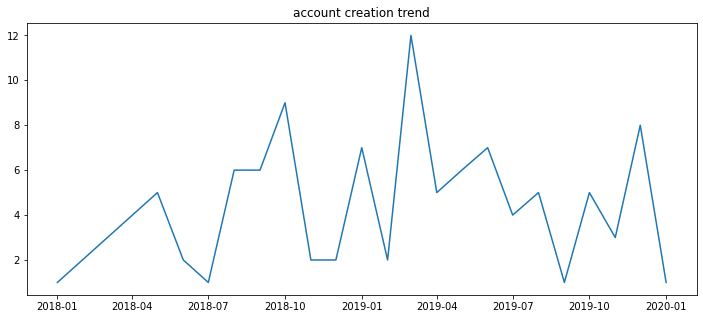

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(pd.DataFrame(pd.to_datetime(vendors['created_at'].apply(lambda x:x[:7]+'-01')).value_counts()).sort_index())
plt.title('account creation trend')
plt.show()

In [ ]:
np.sum(pd.to_datetime(vendors['created_at'].apply(lambda x: x[:10]))<'2019-03-11')/vendors.shape[0]*100

51.0

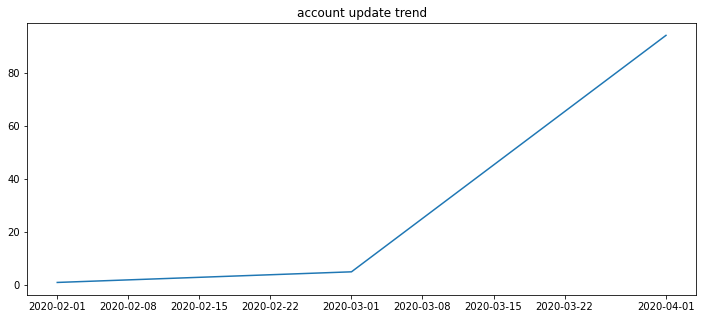

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(pd.DataFrame(pd.to_datetime(vendors['updated_at'].apply(lambda x:x[:7]+'-01')).value_counts()).sort_index())
plt.title('account update trend')
plt.show()

In [ ]:
vendors['updated_at'].apply(lambda x: x[:7]).value_counts()

2020-04    94
2020-03     5
2020-02     1
Name: updated_at, dtype: int64

all the vendors are updated. so removing the column

#2. Preprocessing

In [ ]:
train_customers = pd.read_csv('train_customers.csv')
vendors = pd.read_csv('vendors.csv')
train_locations = pd.read_csv('train_locations.csv')

In [ ]:
#removing unwanted columns from vendors
cols = ['is_open','commission', 'is_akeed_delivering','discount_percentage','status','verified','rank', 'language','primary_tags', 'open_close_flags', 'country_id','city_id',
'device_type','display_orders','one_click_vendor','updated_at','vendor_tag','vendor_tag_name']
for i in vendors.columns:
  if 'time' in i.lower():
    if i != 'prepration time':
      cols.append(i)
vendors = vendors.drop(cols,axis=1)


In [ ]:
#normalizing delivery charges 
vendors.delivery_charge = vendors.delivery_charge.apply(lambda x: 1 if x>0 else 0)

In [ ]:
#normalizing serving_distance
vendors.serving_distance = (vendors.serving_distance - np.min(vendors.serving_distance))/(np.max(vendors.serving_distance) - np.min(vendors.serving_distance))

In [ ]:
#removing unwanted columns from customers data
train_customers = train_customers.drop(['dob','status','verified','language',],axis=1)

In [ ]:
train_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34674 entries, 0 to 34673
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   akeed_customer_id  34674 non-null  object
 1   gender             22520 non-null  object
 2   created_at         34674 non-null  object
 3   updated_at         34674 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


#3. Feature Engineering

In [ ]:
train_customers['is_old'] = (pd.to_datetime(train_customers['created_at'].apply(lambda x: x[:10]))<'2019-09-01').astype('int')
train_customers = train_customers.drop(['created_at'], axis=1)

In [ ]:
train_customers['is_updated'] = (pd.to_datetime(train_customers['updated_at'].apply(lambda x: x[:10]))>='2019-11-01').astype('int')
train_customers = train_customers.drop(['updated_at'], axis=1)

Extracting is_male from gender column. there are different typings of male i.g. Male,male, male e.t.c. So making all of them 'male'

In [ ]:
train_customers.gender = train_customers.gender.apply(lambda x: 1 if str(x).strip().lower()[:4] == 'male' else 0)

In [ ]:
train_customers

akeed_customer_id  gender  is_old  is_updated
0               TCHWPBT       1       1           0
1               ZGFSYCZ       1       1           0
2               S2ALZFL       1       1           0
3               952DBJQ       1       1           0
4               1IX6FXS       1       1           0
...                 ...     ...     ...         ...
34669           JAI79PE       0       0           1
34670           TR75VFL       0       0           1
34671           SQMJ08H       0       0           1
34672           9LW9CHN       0       0           1
34673           LBMRK7A       0       0           1

[34674 rows x 4 columns]

We should not remove location_type as we can differentiate bw 1 customers in 2 places. Filling the NAs with Unknown as it is 45%

In [ ]:
train_locations.location_type = train_locations.location_type.fillna('Unknown')

In [ ]:
train_locations.location_type.value_counts(normalize=True)

Unknown    0.457271
Home       0.331126
Work       0.108247
Other      0.103356
Name: location_type, dtype: float64

#### Merging train customers with location

In [ ]:
train_customers = train_customers.rename({'akeed_customer_id':'customer_id'},axis=1)

In [ ]:
train_customers = train_customers.merge(train_locations,on='customer_id')

In [ ]:
train_customers.customer_id = train_customers.customer_id + '-' + train_customers.location_number.apply(str)

to use the latitude and longitude feature lets collect everyone's distance from (0,0)

In [ ]:
#defining function to mesaure distance bw 2 locations
#ref - https://www.adamsmith.haus/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python

def distance(df):
  R = 6373.0 #radius of the Earth


  #coordinates
  lat1 = df.latitude.apply(math.radians)
  lon1 = df.longitude.apply(math.radians)
  lat2 = df.latitude.apply(lambda x: 0.0)
  lon2 = lat2

  #change in coordinates
  dlon = lon2 - lon1


  dlat = lat2 - lat1

  #Haversine formula
  a = ((dlat / 2)**2).apply(math.sin) + (lat1).apply(math.cos) * (lat2).apply(math.cos) * ((dlon / 2)**2).apply(math.sin)

  c = 2 * (a.apply(np.sqrt)/(1 - a).apply(np.sqrt)).apply(math.atan)
  distance = R * c
  return distance

In [ ]:
train_customers['distance'] = distance(train_customers)

In [ ]:
train_customers = train_customers.drop(['latitude','longitude'],axis=1)

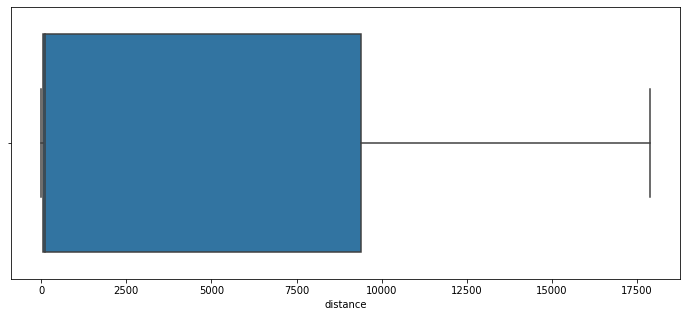

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(train_customers.distance)

In [ ]:
train_customers.distance.describe()

count    58064.000000
mean      3425.132899
std       4664.483215
min          0.063980
25%         64.141527
50%        110.259710
75%       9406.623211
max      17877.084087
Name: distance, dtype: float64

In [ ]:
#train_customers.distance = train_customers.distance.apply(lambda x: 0 if x<65 else (1 if x<111 else (2 if x <9407 else 3)))

In [ ]:
# distance_df = pd.get_dummies(train_customers.distance,drop_first= True)
# c = []
# for i in distance_df.columns:
#     c.append('distance'+str(i))
# distance_df.columns = c
# train_customers = pd.concat([train_customers,distance_df],axis = 1)
# train_customers = train_customers.drop('distance',axis = 1)

Tried to categorize the distance column but that is not that much use full as if some customers 2 location are at same distance category, we will treat them as same customer, but we want to differentiate bw them. So Normalizing the distance column

In [ ]:
max_distance = np.max(train_customers.distance)
min_distance = np.min(train_customers.distance)
train_customers.distance = (train_customers.distance - min_distance)/(max_distance-min_distance)
train_customers.distance = train_customers.distance.fillna(0)

we would remove location number field. as it does not signifies anything 1 can mean office for 1 customer and home for other customer

In [ ]:
location_df = pd.get_dummies(train_customers.location_type,drop_first= True)
train_customers = pd.concat([train_customers,location_df],axis = 1)
train_customers = train_customers.drop('location_number',axis = 1)
train_customers = train_customers.drop('location_type',axis=1)

In [ ]:
train_customers

customer_id  gender  is_old  is_updated  distance  Other  Unknown  Work
0       TCHWPBT-0       1       1           0  0.640909      0        0     1
1       TCHWPBT-1       1       1           0  0.641857      0        0     0
2       TCHWPBT-2       1       1           0  0.526450      0        1     0
3       ZGFSYCZ-0       1       1           0  0.526408      0        0     0
4       ZGFSYCZ-1       1       1           0  0.526739      0        0     0
...           ...     ...     ...         ...       ...    ...      ...   ...
58208   JAI79PE-0       0       0           1  0.001070      0        1     0
58209   TR75VFL-0       0       0           1  0.002890      0        1     0
58210   SQMJ08H-0       0       0           1  0.002451      0        1     0
58211   9LW9CHN-0       0       0           1  0.002813      0        1     0
58212   LBMRK7A-0       0       0           1  0.125338      1        0     0

[58213 rows x 8 columns]

In [ ]:
orders = pd.read_csv('orders.csv')

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135303 entries, 0 to 135302
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   akeed_order_id                  135233 non-null  float64
 1   customer_id                     135303 non-null  object 
 2   item_count                      128378 non-null  float64
 3   grand_total                     135303 non-null  float64
 4   payment_mode                    135303 non-null  int64  
 5   promo_code                      4305 non-null    object 
 6   vendor_discount_amount          135303 non-null  float64
 7   promo_code_discount_percentage  65880 non-null   float64
 8   is_favorite                     100108 non-null  object 
 9   is_rated                        135303 non-null  object 
 10  vendor_rating                   45220 non-null   float64
 11  driver_rating                   135303 non-null  float64
 12  deliverydistance

In [ ]:
vendors = pd.read_csv('vendors.csv')
vendors.head()

id  authentication_id  latitude  longitude vendor_category_en  \
0   4           118597.0 -0.588596   0.754434        Restaurants   
1  13           118608.0 -0.471654   0.744470        Restaurants   
2  20           118616.0 -0.407527   0.643681        Restaurants   
3  23           118619.0 -0.585385   0.753811        Restaurants   
4  28           118624.0  0.480602   0.552850        Restaurants   

   vendor_category_id  delivery_charge  serving_distance  is_open  \
0                 2.0              0.0               6.0      1.0   
1                 2.0              0.7               5.0      1.0   
2                 2.0              0.0               8.0      1.0   
3                 2.0              0.0               5.0      1.0   
4                 2.0              0.7              15.0      1.0   

       OpeningTime  ... open_close_flags                 vendor_tag  \
0  11:00AM-11:30PM  ...              1.0  2,4,5,8,91,22,12,24,16,23   
1  08:30AM-10:30PM  ...              1.0  4,41,51,34,27,15,24,16,28   
2  08:00AM-10:45PM  ...              1.0                  4,8,91,10   
3  10:59AM-10:30PM  ...              1.0                  5,8,30,24   
4  11:00AM-11:45PM  ...              1.0                          5   

                                     vendor_tag_name one_click_vendor  \
0  Arabic,Breakfast,Burgers,Desserts,Free Deliver...                Y   
1  Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...                Y   
2            Breakfast,Desserts,Free Delivery,Indian                Y   
3                      Burgers,Desserts,Fries,Salads                Y   
4                                            Burgers                Y   

   country_id  city_id           created_at           updated_at device_type  \
0         1.0      1.0  2018-01-30 14:42:04  2020-04-07 15:12:43           3   
1         1.0      1.0  2018-05-03 12:32:06  2020-04-05 20:46:03           3   
2         1.0      1.0  2018-05-04 22:28:22  2020-04-07 16:35:55           3   
3         1.0      1.0  2018-05-06 19:20:48  2020-04-02 00:56:17           3   
4         1.0      1.0  2018-05-17 22:12:38  2020-04-05 15:57:41           3   

   display_orders  
0               1  
1               1  
2               1  
3               1  
4               1  

[5 rows x 59 columns]

#4. Modeling

##4.1. Matrix Factorization(explicit feedback)

For 1st approach we will take only the rated orders

#### Modifying orders data

Removing the NA and 0 ratings

In [ ]:
rated_orders = orders[['customer_id','LOCATION_NUMBER','vendor_id','vendor_rating']][~orders.vendor_rating.isna()]
rated_orders = rated_orders[rated_orders.vendor_rating!=0]

In [ ]:
rated_orders['customer_id'] = rated_orders['customer_id']+'-'+rated_orders['LOCATION_NUMBER'].apply(str)
rated_orders = rated_orders.drop(['LOCATION_NUMBER'],axis=1)

In [ ]:
rated_orders  = rated_orders.reset_index(drop=True)

In [ ]:
print(rated_orders.shape[0])
len(np.unique(rated_orders.customer_id + rated_orders.vendor_id.apply(str)))

20045


14051

some users have ordered from same resturant from same location multiple times.
need to remove those duplicates

In [ ]:
rated_orders = pd.DataFrame(rated_orders.groupby(['customer_id','vendor_id'])['vendor_rating'].mean()).reset_index()

#### Model

In [ ]:
customer_id_index = np.unique(rated_orders.customer_id)
df_customer_id_index = pd.DataFrame(customer_id_index)
df_customer_id_index = df_customer_id_index.reset_index()
df_customer_id_index.rename(columns={'index':'customer_idx',0:'customer_id'}, inplace=True)
df_customer_id_index

customer_idx customer_id
0                0   00HWUU3-1
1                1   00OT8JX-3
2                2   00OT8JX-4
3                3   010DVV3-0
4                4   018GT0H-2
...            ...         ...
9271          9271   ZZJSJYC-0
9272          9272   ZZJX0AR-0
9273          9273   ZZP5BHU-0
9274          9274   ZZRJABJ-2
9275          9275   ZZY3N0D-1

[9276 rows x 2 columns]

In [ ]:
vendor_id_index = np.unique(rated_orders.vendor_id)
df_vendor_id_index = pd.DataFrame(vendor_id_index)
df_vendor_id_index = df_vendor_id_index.reset_index()
df_vendor_id_index.rename(columns={'index':'vendor_idx',0:'vendor_id'}, inplace=True)
df_vendor_id_index

vendor_idx  vendor_id
0            0          4
1            1         13
2            2         20
3            3         23
4            4         28
..         ...        ...
95          95        849
96          96        855
97          97        856
98          98        858
99          99        907

[100 rows x 2 columns]

In [ ]:
rated_orders = rated_orders.merge(df_vendor_id_index,on='vendor_id')
rated_orders = rated_orders.merge(df_customer_id_index,on='customer_id')

In [ ]:
rated_orders = rated_orders.drop(['vendor_id','customer_id'],axis =1)
rated_orders = rated_orders[['customer_idx','vendor_idx','vendor_rating']]
rated_orders.shape

(14051, 3)

In [ ]:
rated_orders_train, rated_orders_test = train_test_split(rated_orders,test_size=0.1,random_state=20)

In [ ]:
z = rated_orders.pivot_table(index='customer_idx',columns='vendor_idx',values = 'vendor_rating')

In [ ]:
z

vendor_idx     0   1   2   3   4    5   6   7   8   9   ...  90   91  92  93  \
customer_idx                                            ...                    
0             NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
1             5.0 NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  5.0 NaN NaN   
2             5.0 NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
3             NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
4             NaN NaN NaN NaN NaN  5.0 NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
...           ...  ..  ..  ..  ..  ...  ..  ..  ..  ..  ...  ..  ...  ..  ..   
9271          NaN NaN NaN NaN NaN  5.0 NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
9272          NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
9273          NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
9274          NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
9275          NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  NaN NaN NaN   

vendor_idx    94  95  96   97   98  99  
customer_idx                            
0            NaN NaN NaN  NaN  NaN NaN  
1            NaN NaN NaN  NaN  NaN NaN  
2            NaN NaN NaN  NaN  5.0 NaN  
3            NaN NaN NaN  NaN  NaN NaN  
4            NaN NaN NaN  NaN  NaN NaN  
...           ..  ..  ..  ...  ...  ..  
9271         NaN NaN NaN  5.0  NaN NaN  
9272         NaN NaN NaN  NaN  NaN NaN  
9273         NaN NaN NaN  NaN  NaN NaN  
9274         NaN NaN NaN  NaN  NaN NaN  
9275         NaN NaN NaN  NaN  NaN NaN  

[9276 rows x 100 columns]

In [ ]:
for i,j in zip(rated_orders_test.customer_idx,rated_orders_test.vendor_idx):
  z.loc[i,j] = np.NaN

In [ ]:
rated_orders_train

customer_idx  vendor_idx  vendor_rating
10430          6821          52       4.000000
2221           9077          38       4.454545
5740           4418          80       5.000000
104            2517          18       5.000000
7481           3749          31       3.000000
...             ...         ...            ...
9620           7622          14       5.000000
7068           6257          34       3.000000
7391           6300          28       5.000000
4367           7881          93       5.000000
10714          9008          95       5.000000

[12645 rows x 3 columns]

In [ ]:
z.loc[6821,52] - 0 ==z.loc[6821,52]

True

In [ ]:
adjacency_matrix = csr_matrix(z)

In [ ]:
adjacency_matrix.shape

(9276, 100)

In [ ]:
adjacency_matrix.data = np.nan_to_num(adjacency_matrix.data, copy=False)

In [ ]:
U, Sigma, VT = randomized_svd(adjacency_matrix, n_components=50, random_state=None)

In [ ]:
mu = rated_orders_train.vendor_rating.mean()

In [ ]:
def initialize(dim):
    '''In this function, we will initialize bias value 'B' and 'C'.'''
    # initalize the value to zeros 
    # return output as a list of zeros 
    a = np.zeros(dim)
    

    return a

In [ ]:
def derivative_db(user_id,vendor_id,rating,U,V,mu,alpha):
    '''In this function, we will compute dL/db_i'''
    user_id = int(user_id)
    vendor_id = int(vendor_id)
    return alpha * 2* b_i[user_id] - 2*(rated_orders[(rated_orders.customer_idx==user_id)&(rated_orders.vendor_idx==vendor_id)].vendor_rating.values -mu- b_i[user_id] - c_j[vendor_id]-(U[user_id,:]@V[:,vendor_id]))


In [ ]:
def derivative_dc(user_id,vendor_id,rating,U,V,mu, alpha):
    '''In this function, we will compute dL/dc_j'''
    user_id = int(user_id)
    vendor_id = int(vendor_id)
    return alpha * 2* c_j[vendor_id] - 2*(rated_orders[(rated_orders.customer_idx==user_id)&(rated_orders.vendor_idx==vendor_id)].vendor_rating.values -mu- b_i[user_id] - c_j[vendor_id]-(U[user_id,:]@V[:,vendor_id]))


In [ ]:
rated_orders

customer_idx  vendor_idx  vendor_rating
0                 0          68            5.0
1               180          68            4.0
2               180          18            4.6
3               180          73            1.0
4               263          68            4.0
...             ...         ...            ...
14046          5161          39            4.0
14047          7827          39            5.0
14048          8529          39            5.0
14049          8874          39            4.0
14050          9130          39            3.0

[14051 rows x 3 columns]

In [ ]:
learning_rate = 0.001
b_i=initialize(adjacency_matrix.shape[0])
c_j=initialize(adjacency_matrix.shape[1])
alpha = 0.01
train_RMSE = []
test_RMSE = []
train_MAPE = []
test_MAPE = []
from tqdm import tqdm

epochs = 50
for i in tqdm(range(epochs)):
    for j in range(len(rated_orders)):
      if z.loc[rated_orders.iloc[j][0],rated_orders.iloc[j][1]] - 0 == z.loc[rated_orders.iloc[j][0],rated_orders.iloc[j][1]]:
        b_i[int(rated_orders.iloc[j][0])] = b_i[int(rated_orders.iloc[j][0])] - learning_rate* derivative_db(rated_orders.iloc[j][0],rated_orders.iloc[j][1],rated_orders.iloc[j][2],U,VT,mu,alpha)
        c_j[int(rated_orders.iloc[j][1])] = c_j[int(rated_orders.iloc[j][1])] - learning_rate* derivative_dc(rated_orders.iloc[j][0],rated_orders.iloc[j][1],rated_orders.iloc[j][2],U,VT,mu,alpha)
    y_pred_train = np.array([mu+b_i[int(rated_orders_train.iloc[j][0])]+c_j[int(rated_orders_train.iloc[j][1])]+U[int(rated_orders_train.iloc[j][0])]@VT[:,int(rated_orders_train.iloc[j][1])] for j in range(len(rated_orders_train))])
    train_RMSE.append((np.square(np.array(rated_orders_train.vendor_rating) - y_pred_train).sum())/len(rated_orders_train))
    train_MAPE.append(np.mean(np.abs(np.array(rated_orders_train.vendor_rating) - y_pred_train)/rated_orders_train.vendor_rating)*100)
    print('train_RMSE:',train_RMSE[-1])
    print('train_MAPE:',train_MAPE[-1])

    #test
    y_pred_test = np.array([mu+b_i[int(rated_orders_test.iloc[j][0])]+c_j[int(rated_orders_test.iloc[j][1])]+U[int(rated_orders_test.iloc[j][0])]@VT[:,int(rated_orders_test.iloc[j][1])] for j in range(len(rated_orders_test))])
    test_RMSE.append((np.square(np.array(rated_orders_test.vendor_rating) - y_pred_test).sum())/len(rated_orders_test))
    test_MAPE.append(np.mean(np.abs(np.array(rated_orders_test.vendor_rating) - y_pred_test)/rated_orders_test.vendor_rating)*100)
    print('test_RMSE:',test_RMSE[-1])
    print('test_MAPE:',test_MAPE[-1])

  0%|          | 0/50 [00:00<?, ?it/s]

train_RMSE: 1.2133725742956345
train_MAPE: 35.6725806513228


  2%|▏         | 1/50 [00:52<42:57, 52.61s/it]

test_RMSE: 1.1764075870076114
test_MAPE: 33.83800783985417
train_RMSE: 1.1956831828249876
train_MAPE: 35.30895438686903


  4%|▍         | 2/50 [01:43<41:24, 51.77s/it]

test_RMSE: 1.1689503461470157
test_MAPE: 33.607896896807
train_RMSE: 1.1833108683657891
train_MAPE: 35.04492119849864


  6%|▌         | 3/50 [02:35<40:37, 51.85s/it]

test_RMSE: 1.1654735619545582
test_MAPE: 33.47913774222018
train_RMSE: 1.1734403406793747
train_MAPE: 34.835286387854836


  8%|▊         | 4/50 [03:27<39:35, 51.63s/it]

test_RMSE: 1.163599601409335
test_MAPE: 33.38782169938626
train_RMSE: 1.164982694780047
train_MAPE: 34.65712556478891


 10%|█         | 5/50 [04:19<38:58, 51.96s/it]

test_RMSE: 1.1624718318529794
test_MAPE: 33.31655059787636
train_RMSE: 1.1573971116390813
train_MAPE: 34.499426548073


 12%|█▏        | 6/50 [05:11<37:59, 51.80s/it]

test_RMSE: 1.1617007734986167
test_MAPE: 33.25866860501772
train_RMSE: 1.1503808229170824
train_MAPE: 34.3566553108937


 14%|█▍        | 7/50 [06:02<37:03, 51.71s/it]

test_RMSE: 1.1610927976920657
test_MAPE: 33.210701040225175
train_RMSE: 1.1437535261798781
train_MAPE: 34.225479731928054


 16%|█▌        | 8/50 [06:54<36:15, 51.79s/it]

test_RMSE: 1.1605492636530115
test_MAPE: 33.170031032970144
train_RMSE: 1.1374037408957864
train_MAPE: 34.1037679788327


 18%|█▊        | 9/50 [07:45<35:12, 51.52s/it]

test_RMSE: 1.1600206247572582
test_MAPE: 33.13553658191374
train_RMSE: 1.1312606438204857
train_MAPE: 33.98897717042863


 20%|██        | 10/50 [08:36<34:09, 51.24s/it]

test_RMSE: 1.159483376922932
test_MAPE: 33.10568248186954
train_RMSE: 1.1252782032000272
train_MAPE: 33.879729248277826


 22%|██▏       | 11/50 [09:28<33:29, 51.53s/it]

test_RMSE: 1.158927876468094
test_MAPE: 33.07928922027597
train_RMSE: 1.119425850572916
train_MAPE: 33.77487009013011


 24%|██▍       | 12/50 [10:19<32:32, 51.37s/it]

test_RMSE: 1.1583517294569987
test_MAPE: 33.05550896860648
train_RMSE: 1.113682838922834
train_MAPE: 33.6736644655124


 26%|██▌       | 13/50 [11:12<31:59, 51.87s/it]

test_RMSE: 1.1577561649002783
test_MAPE: 33.03354523415195
train_RMSE: 1.1080347595519253
train_MAPE: 33.57555648094543


 28%|██▊       | 14/50 [12:03<30:57, 51.59s/it]

test_RMSE: 1.1571440488231912
test_MAPE: 33.01303348172425
train_RMSE: 1.1024713563336446
train_MAPE: 33.4800563211267


 30%|███       | 15/50 [12:53<29:55, 51.31s/it]

test_RMSE: 1.1565188140917508
test_MAPE: 32.993688594876716
train_RMSE: 1.0969851348179216
train_MAPE: 33.386816349990184


 32%|███▏      | 16/50 [13:45<29:10, 51.49s/it]

test_RMSE: 1.1558839041008298
test_MAPE: 32.9756180455093
train_RMSE: 1.0915704658142804
train_MAPE: 33.295379499240816


 34%|███▍      | 17/50 [14:36<28:13, 51.32s/it]

test_RMSE: 1.1552425037889336
test_MAPE: 32.95860833927829
train_RMSE: 1.0862230005927351
train_MAPE: 33.20545817607364


 36%|███▌      | 18/50 [15:27<27:17, 51.16s/it]

test_RMSE: 1.1545974290742766
test_MAPE: 32.94258359721247
train_RMSE: 1.0809392847372308
train_MAPE: 33.11690068498326


 38%|███▊      | 19/50 [16:19<26:36, 51.51s/it]

test_RMSE: 1.1539511011501307
test_MAPE: 32.92702181201566
train_RMSE: 1.0757164999993258
train_MAPE: 33.02953562953652


 40%|████      | 20/50 [17:10<25:40, 51.34s/it]

test_RMSE: 1.1533055638253435
test_MAPE: 32.91234838315774
train_RMSE: 1.070552289483491
train_MAPE: 32.94325970483571


 42%|████▏     | 21/50 [18:02<24:55, 51.57s/it]

test_RMSE: 1.1526625204289678
test_MAPE: 32.89808382803872
train_RMSE: 1.0654446376439988
train_MAPE: 32.857951099525415


 44%|████▍     | 22/50 [18:53<23:56, 51.29s/it]

test_RMSE: 1.1520233774007813
test_MAPE: 32.884062292867675
train_RMSE: 1.0603917867145953
train_MAPE: 32.773584790613356


 46%|████▌     | 23/50 [19:44<23:01, 51.16s/it]

test_RMSE: 1.1513892877976586
test_MAPE: 32.87024631971323
train_RMSE: 1.0553921776203716
train_MAPE: 32.69007236007573


 48%|████▊     | 24/50 [20:36<22:13, 51.31s/it]

test_RMSE: 1.1507611914279023
test_MAPE: 32.8566061239344
train_RMSE: 1.05044440753113
train_MAPE: 32.60731798807023


 50%|█████     | 25/50 [21:27<21:21, 51.28s/it]

test_RMSE: 1.1501398502722067
test_MAPE: 32.84311801894452
train_RMSE: 1.0455471988646863
train_MAPE: 32.525246783367315


 52%|█████▏    | 26/50 [22:22<21:00, 52.51s/it]

test_RMSE: 1.1495258789019185
test_MAPE: 32.82976317171064
train_RMSE: 1.0406993762697876
train_MAPE: 32.44386571997983


 54%|█████▍    | 27/50 [23:17<20:24, 53.23s/it]

test_RMSE: 1.1489197701408465
test_MAPE: 32.81652661699253
train_RMSE: 1.035899849245658
train_MAPE: 32.363205189491374


 56%|█████▌    | 28/50 [24:08<19:18, 52.66s/it]

test_RMSE: 1.14832191645917
test_MAPE: 32.803396474711434
train_RMSE: 1.0311475987994791
train_MAPE: 32.28315728718772


 58%|█████▊    | 29/50 [25:01<18:22, 52.52s/it]

test_RMSE: 1.1477326276682813
test_MAPE: 32.790363327296404
train_RMSE: 1.0264416670387717
train_MAPE: 32.203721226215606


 60%|██████    | 30/50 [25:52<17:23, 52.16s/it]

test_RMSE: 1.1471521454802422
test_MAPE: 32.77741972338802
train_RMSE: 1.0217811489285686
train_MAPE: 32.12488750482743


 62%|██████▏   | 31/50 [26:44<16:29, 52.06s/it]

test_RMSE: 1.1465806554490023
test_MAPE: 32.76456888720121
train_RMSE: 1.0171651856690644
train_MAPE: 32.04661668808432


 64%|██████▍   | 32/50 [27:36<15:36, 52.03s/it]

test_RMSE: 1.146018296747381
test_MAPE: 32.7518493331525
train_RMSE: 1.012592959304022
train_MAPE: 31.968869702776225


 66%|██████▌   | 33/50 [28:27<14:40, 51.77s/it]

test_RMSE: 1.1454651701675245
test_MAPE: 32.73924516380222
train_RMSE: 1.0080636882772185
train_MAPE: 31.891700631402507


 68%|██████▊   | 34/50 [29:19<13:51, 51.98s/it]

test_RMSE: 1.1449213446698858
test_MAPE: 32.726731502221654
train_RMSE: 1.003576623729078
train_MAPE: 31.81504349968146


 70%|███████   | 35/50 [30:10<12:54, 51.64s/it]

test_RMSE: 1.1443868627498595
test_MAPE: 32.71428838317908
train_RMSE: 0.9991310463786102
train_MAPE: 31.73888427125437


 72%|███████▏  | 36/50 [31:01<11:58, 51.35s/it]

test_RMSE: 1.1438617448429387
test_MAPE: 32.70191400311932
train_RMSE: 0.9947262638737315
train_MAPE: 31.6632215999785


 74%|███████▍  | 37/50 [31:53<11:10, 51.59s/it]

test_RMSE: 1.143345992948564
test_MAPE: 32.6896069789541
train_RMSE: 0.9903616085205503
train_MAPE: 31.588083802216556


 76%|███████▌  | 38/50 [32:44<10:15, 51.28s/it]

test_RMSE: 1.142839593619022
test_MAPE: 32.67742012705529
train_RMSE: 0.9860364353223906
train_MAPE: 31.513405654910574


 78%|███████▊  | 39/50 [33:34<09:22, 51.17s/it]

test_RMSE: 1.142342520431959
test_MAPE: 32.665490392672666
train_RMSE: 0.981750120274334
train_MAPE: 31.439149033780183


 80%|████████  | 40/50 [34:26<08:33, 51.40s/it]

test_RMSE: 1.1418547360424
test_MAPE: 32.65372687366075
train_RMSE: 0.9775020588703407
train_MAPE: 31.365366027818297


 82%|████████▏ | 41/50 [35:17<07:40, 51.21s/it]

test_RMSE: 1.1413761938917752
test_MAPE: 32.64213429355763
train_RMSE: 0.973291664788597
train_MAPE: 31.292082292969916


 84%|████████▍ | 42/50 [36:09<06:51, 51.47s/it]

test_RMSE: 1.1409068396365771
test_MAPE: 32.63067187260236
train_RMSE: 0.9691183687273492
train_MAPE: 31.219271535422948


 86%|████████▌ | 43/50 [37:01<06:00, 51.52s/it]

test_RMSE: 1.1404466123472803
test_MAPE: 32.619352737572996
train_RMSE: 0.9649816173686258
train_MAPE: 31.146905982060936


 88%|████████▊ | 44/50 [37:52<05:08, 51.41s/it]

test_RMSE: 1.1399954455185015
test_MAPE: 32.60808887081557
train_RMSE: 0.9608808724512877
train_MAPE: 31.074942680528128


 90%|█████████ | 45/50 [38:44<04:17, 51.55s/it]

test_RMSE: 1.1395532679235953
test_MAPE: 32.59690303751627
train_RMSE: 0.9568156099380593
train_MAPE: 31.003387654930158


 92%|█████████▏| 46/50 [39:35<03:25, 51.38s/it]

test_RMSE: 1.1391200043406464
test_MAPE: 32.585964507208644
train_RMSE: 0.952785319263759
train_MAPE: 30.93226401359358


 94%|█████████▍| 47/50 [40:27<02:34, 51.62s/it]

test_RMSE: 1.1386955761717679
test_MAPE: 32.57511440832251
train_RMSE: 0.9487895026540223
train_MAPE: 30.86153322634616


 96%|█████████▌| 48/50 [41:18<01:42, 51.40s/it]

test_RMSE: 1.1382799019735774
test_MAPE: 32.56431955399238
train_RMSE: 0.9448276745054927
train_MAPE: 30.79122911687948


 98%|█████████▊| 49/50 [42:09<00:51, 51.40s/it]

test_RMSE: 1.1378728979134474
test_MAPE: 32.55358010475169
train_RMSE: 0.9408993608198416
train_MAPE: 30.721301185443185


100%|██████████| 50/50 [43:02<00:00, 51.64s/it]

test_RMSE: 1.1374744781634931
test_MAPE: 32.54289621446903


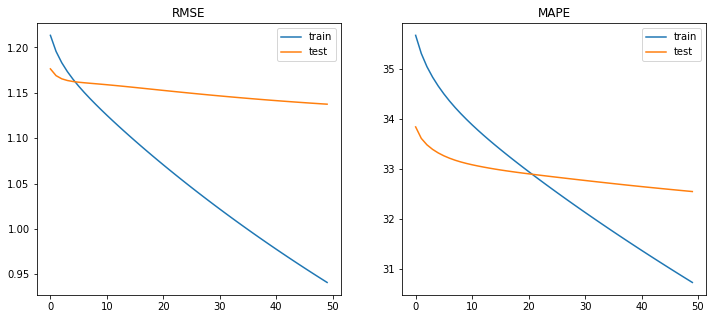

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_RMSE,label='train')
plt.plot(test_RMSE,label='test')
plt.title('RMSE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_MAPE,label='train')
plt.plot(test_MAPE,label='test')
plt.title('MAPE')
plt.legend()
plt.show()

In [ ]:
pred = {}
for i in tqdm(rated_orders.customer_idx.values):
  for j in rated_orders.vendor_idx.values:
    pred[str(i)+'-'+str(j)] = mu+b_i[i]+c_j[j]+U[i]@VT[:,j]

In [ ]:
np.max(list(pred.values()))
pred = pd.DataFrame({'id':list(pred.keys()),'ratings':list(pred.values())})

In [ ]:
pred.ratings = pred.ratings.apply(lambda x: 0 if x<0 else x)
pred.ratings = pred.ratings.apply(lambda x: 5 if x>5 else x)

In [ ]:
pred['customer_idx'] = pred.id.apply(lambda x: x.split('-')[0])
pred['vendor_idx'] = pred.id.apply(lambda x: x.split('-')[1])

In [ ]:
pred.customer_idx = pred.customer_idx.apply(str)
df_customer_id_index.customer_idx = df_customer_id_index.customer_idx.apply(str)
df_vendor_id_index.vendor_idx = df_vendor_id_index.vendor_idx.apply(str)

In [ ]:
pred = pred.merge(df_customer_id_index,on='customer_idx')
pred = pred.merge(df_vendor_id_index,on='vendor_idx')

In [ ]:
pred = pred[['customer_id','vendor_id','ratings']]

In [ ]:
pred.to_csv('pred_MF.csv',index=False)

In [ ]:
pred

In [ ]:
rated_orders.customer_idx = rated_orders.customer_idx.apply(str)
rated_orders.vendor_idx = rated_orders.vendor_idx.apply(str)

In [ ]:
rated_orders = rated_orders.merge(df_customer_id_index,on='customer_idx')
rated_orders = rated_orders.merge(df_vendor_id_index,on='vendor_idx')

In [ ]:
rated_orders = rated_orders[['customer_id','vendor_id','vendor_rating']]

In [ ]:
for i,j,k in tqdm(zip(rated_orders.customer_id,rated_orders.vendor_id,rated_orders.vendor_rating)):
  pred[(pred.customer_id == i) & (pred.vendor_id == j)]['vendor_rating'] = k

##4.2. MF with explicit + implicit feerback

We will consider the rated orders as well whether the user have ordered from that vendor or not

In [ ]:
all_orders = orders[['customer_id','LOCATION_NUMBER','vendor_id','vendor_rating']]
all_orders['customer_id'] = all_orders['customer_id']+'-'+all_orders['LOCATION_NUMBER'].apply(str)
all_orders = all_orders.drop(['LOCATION_NUMBER'],axis=1)
rated_orders = all_orders[~orders.vendor_rating.isna()]
rated_orders = rated_orders[rated_orders.vendor_rating!=0]
rated_orders  = rated_orders.reset_index(drop=True)

Modifying all_orders to get the implicit feedback whether the user have ordered from a resturant or not

In [ ]:
all_orders.vendor_rating = 1
all_orders = all_orders.drop_duplicates()
all_orders.shape

(80142, 3)

In [ ]:
print(rated_orders.shape[0])
len(np.unique(rated_orders.customer_id + rated_orders.vendor_id.apply(str)))

20045


14051

some users have ordered from same resturant from same location multiple times.
need to remove those duplicates

In [ ]:
rated_orders = pd.DataFrame(rated_orders.groupby(['customer_id','vendor_id'])['vendor_rating'].mean()).reset_index()

In [ ]:
customer_id_index = np.unique(rated_orders.customer_id)
df_customer_id_index = pd.DataFrame(customer_id_index)
df_customer_id_index = df_customer_id_index.reset_index()
df_customer_id_index.rename(columns={'index':'customer_idx',0:'customer_id'}, inplace=True)
df_customer_id_index

customer_idx customer_id
0                0   00HWUU3-1
1                1   00OT8JX-3
2                2   00OT8JX-4
3                3   010DVV3-0
4                4   018GT0H-2
...            ...         ...
9271          9271   ZZJSJYC-0
9272          9272   ZZJX0AR-0
9273          9273   ZZP5BHU-0
9274          9274   ZZRJABJ-2
9275          9275   ZZY3N0D-1

[9276 rows x 2 columns]

In [ ]:
vendor_id_index = np.unique(rated_orders.vendor_id)
df_vendor_id_index = pd.DataFrame(vendor_id_index)
df_vendor_id_index = df_vendor_id_index.reset_index()
df_vendor_id_index.rename(columns={'index':'vendor_idx',0:'vendor_id'}, inplace=True)
df_vendor_id_index

vendor_idx  vendor_id
0            0          4
1            1         13
2            2         20
3            3         23
4            4         28
..         ...        ...
95          95        849
96          96        855
97          97        856
98          98        858
99          99        907

[100 rows x 2 columns]

In [ ]:
rated_orders = rated_orders.merge(df_vendor_id_index,on='vendor_id')
rated_orders = rated_orders.merge(df_customer_id_index,on='customer_id')

In [ ]:
rated_orders = rated_orders.drop(['vendor_id','customer_id'],axis =1)
rated_orders = rated_orders[['customer_idx','vendor_idx','vendor_rating']]
rated_orders.shape

(14051, 3)

In [ ]:
all_orders_test = all_orders.merge(df_vendor_id_index,on='vendor_id')
all_orders_test = all_orders_test.merge(df_customer_id_index,on='customer_id')
all_orders_test = all_orders_test.drop(['vendor_id','customer_id'],axis =1)
all_orders_test = all_orders_test[['customer_idx','vendor_idx','vendor_rating']]
all_orders_test.shape

(24433, 3)

In [ ]:
rated_orders_train, rated_orders_test = train_test_split(rated_orders,test_size=0.1,random_state=20)

In [ ]:
all_orders = rated_orders_train.copy()
all_orders.vendor_rating = 1

In [ ]:
z_rated = rated_orders.pivot_table(index='customer_idx',columns='vendor_idx',values = 'vendor_rating')

In [ ]:
z_rated

vendor_idx     0   1   2   3   4    5   6   7   8   9   ...  90   91  92  93  \
customer_idx                                            ...                    
0             NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
1             5.0 NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  5.0 NaN NaN   
2             5.0 NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
3             NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
4             NaN NaN NaN NaN NaN  5.0 NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
...           ...  ..  ..  ..  ..  ...  ..  ..  ..  ..  ...  ..  ...  ..  ..   
9271          NaN NaN NaN NaN NaN  5.0 NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
9272          NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
9273          NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
9274          NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  NaN NaN NaN   
9275          NaN NaN NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN  NaN NaN NaN   

vendor_idx    94  95  96   97   98  99  
customer_idx                            
0            NaN NaN NaN  NaN  NaN NaN  
1            NaN NaN NaN  NaN  NaN NaN  
2            NaN NaN NaN  NaN  5.0 NaN  
3            NaN NaN NaN  NaN  NaN NaN  
4            NaN NaN NaN  NaN  NaN NaN  
...           ..  ..  ..  ...  ...  ..  
9271         NaN NaN NaN  5.0  NaN NaN  
9272         NaN NaN NaN  NaN  NaN NaN  
9273         NaN NaN NaN  NaN  NaN NaN  
9274         NaN NaN NaN  NaN  NaN NaN  
9275         NaN NaN NaN  NaN  NaN NaN  

[9276 rows x 100 columns]

In [ ]:
# removing the test ratings for testing purpose
for i,j in zip(rated_orders_test.customer_idx,rated_orders_test.vendor_idx):
  z_rated.loc[i,j] = np.NaN

In [ ]:
rated_orders_train

customer_idx  vendor_idx  vendor_rating
10430          6821          52       4.000000
2221           9077          38       4.454545
5740           4418          80       5.000000
104            2517          18       5.000000
7481           3749          31       3.000000
...             ...         ...            ...
9620           7622          14       5.000000
7068           6257          34       3.000000
7391           6300          28       5.000000
4367           7881          93       5.000000
10714          9008          95       5.000000

[12645 rows x 3 columns]

In [ ]:
adjacency_matrix = csr_matrix(z_rated)

In [ ]:
adjacency_matrix.shape

(9276, 100)

In [ ]:
adjacency_matrix.data = np.nan_to_num(adjacency_matrix.data, copy=False)

In [ ]:
U, Sigma, VT = randomized_svd(adjacency_matrix, n_components=100, random_state=None)

In [ ]:
z_all_train = all_orders.pivot_table(index='vendor_idx',columns='customer_idx',values = 'vendor_rating')
z_all_test = all_orders_test.pivot_table(index='vendor_idx',columns='customer_idx',values = 'vendor_rating')

In [ ]:
z_all_train = z_all_train.fillna(0)
z_all_test = z_all_test.fillna(0)
z_all_train

customer_idx  0     1     2     3     4     5     6     7     8     9     ...  \
vendor_idx                                                                ...   
0              0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1              0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2              0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3              0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4              0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
95             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
96             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
97             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
98             0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
99             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

customer_idx  9266  9267  9268  9269  9270  9271  9272  9273  9274  9275  
vendor_idx                                                                
0              0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1              0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2              1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3              0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4              0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
95             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
96             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
97             0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  
98             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
99             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[100 rows x 8607 columns]

In [ ]:
svd = TruncatedSVD(n_components=100, algorithm='randomized', random_state=15)
trunc_svd = svd.fit_transform(z_all_train)
trunc_svd_test = svd.fit_transform(z_all_test)

In [ ]:
trunc_svd

array([[ 6.43530177e-03,  4.59465701e-01,  3.65762249e-01, ...,
         5.15477007e-04, -6.40941771e-05, -1.94331135e-05],
       [ 1.26577822e-03,  1.25039370e-01,  9.84190007e-02, ...,
         3.72025918e-03,  8.00384361e-05,  8.60500958e-06],
       [ 4.75371813e-03,  5.81009295e-01,  4.53477733e-01, ...,
         1.99192861e-03, -1.70004660e-04, -1.62050411e-05],
       ...,
       [ 3.56481580e-03,  1.34287236e+00,  3.25835342e-01, ...,
         1.38097515e-03, -4.77347096e-05, -3.38636183e-06],
       [ 1.97999840e-03,  1.07538936e+00, -6.25769709e-02, ...,
         1.91359365e-03,  5.56853538e-06,  1.74377170e-06],
       [ 1.15016333e-16, -7.36984757e-17, -3.02142715e-16, ...,
         3.58182054e-16, -9.58942156e-17, -6.45646941e-16]])

In [ ]:
mu = rated_orders_train.vendor_rating.mean()

In [ ]:
def initialize(dim):
    '''In this function, we will initialize bias value 'B' and 'C'.'''
    # initalize the value to zeros 
    # return output as a list of zeros 
    a = np.zeros(dim)
    

    return a

In [ ]:
def derivative_db(user_id,vendor_id,rating,U,V,mu,alpha):
    '''In this function, we will compute dL/db_i'''
    user_id = int(user_id)
    vendor_id = int(vendor_id)
    pred = mu+ b_i[user_id] + c_j[vendor_id]+(U[user_id,:]@(V[:,vendor_id]+(np.sum(rated_orders[rated_orders.customer_idx==user_id].vendor_rating**2)**(-0.5)*\
                                                                                                          (np.sum(trunc_svd[np.array(rated_orders[rated_orders.customer_idx==user_id].vendor_idx)],axis=0)))))
    return alpha * 2* b_i[user_id] - 2*(rated_orders[(rated_orders.customer_idx==user_id)&(rated_orders.vendor_idx==vendor_id)].vendor_rating.values-pred)*\
                                                  (pred -b_i[user_id] )


In [ ]:
def derivative_dc(user_id,vendor_id,rating,U,V,mu, alpha):
    '''In this function, we will compute dL/dc_j'''
    user_id = int(user_id)
    vendor_id = int(vendor_id)
    pred = mu+ b_i[user_id] + c_j[vendor_id]+(U[user_id,:]@(V[:,vendor_id]+(np.sum(rated_orders[rated_orders.customer_idx==user_id].vendor_rating**2)**(-0.5)*\
                                                                                                          (np.sum(trunc_svd[np.array(rated_orders[rated_orders.customer_idx==user_id].vendor_idx)],axis=0)))))
    return alpha * 2* c_j[vendor_id] - 2*(rated_orders[(rated_orders.customer_idx==user_id)&(rated_orders.vendor_idx==vendor_id)].vendor_rating.values-pred)*\
                                                  (pred -c_j[vendor_id] )


In [ ]:
rated_orders

customer_idx  vendor_idx  vendor_rating
0                 0          68            5.0
1               180          68            4.0
2               180          18            4.6
3               180          73            1.0
4               263          68            4.0
...             ...         ...            ...
14046          5161          39            4.0
14047          7827          39            5.0
14048          8529          39            5.0
14049          8874          39            4.0
14050          9130          39            3.0

[14051 rows x 3 columns]

In [ ]:
learning_rate = 0.001
b_i=initialize(adjacency_matrix.shape[0])
c_j=initialize(adjacency_matrix.shape[1])
alpha = 0.01
train_RMSE = []
test_RMSE = []
train_MAPE = []
test_MAPE = []
from tqdm import tqdm

epochs = 50
for i in tqdm(range(epochs)):
    for j in range(len(rated_orders)):
      customer_idx = rated_orders.iloc[j,0]
      vendor_idx = rated_orders.iloc[j,1]
      if z_rated.loc[rated_orders.iloc[j][0],rated_orders.iloc[j][1]] - 0 == z_rated.loc[rated_orders.iloc[j][0],rated_orders.iloc[j][1]]:
        b_i[int(rated_orders.iloc[j][0])] = b_i[int(rated_orders.iloc[j][0])] - learning_rate* derivative_db(rated_orders.iloc[j][0],rated_orders.iloc[j][1],rated_orders.iloc[j][2],U,VT,mu,alpha)
        c_j[int(rated_orders.iloc[j][1])] = c_j[int(rated_orders.iloc[j][1])] - learning_rate* derivative_dc(rated_orders.iloc[j][0],rated_orders.iloc[j][1],rated_orders.iloc[j][2],U,VT,mu,alpha)
    y_pred_train = np.array([mu+b_i[int(rated_orders_train.iloc[j][0])]+c_j[int(rated_orders_train.iloc[j][1])]+U[int(rated_orders_train.iloc[j][0])]@(VT[:,int(rated_orders_train.iloc[j][1])]+\
                                                                                                                    (np.sum(rated_orders_train[rated_orders_train.customer_idx==rated_orders_train.iloc[j,0]].vendor_rating**2)**(-0.5)*\
                                                                                                          (np.sum(trunc_svd[np.array(rated_orders_train[rated_orders_train.customer_idx==rated_orders_train.iloc[j,0]].vendor_idx)],axis=0)))) for j in range(len(rated_orders_train))])
    
    
    
    train_RMSE.append((np.square(np.array(rated_orders_train.vendor_rating) - y_pred_train).sum())/len(rated_orders_train))
    train_MAPE.append(np.mean(np.abs(np.array(rated_orders_train.vendor_rating) - y_pred_train)/rated_orders_train.vendor_rating)*100)

    print('train_RMSE:',train_RMSE[-1])
    print('train_MAPE:',train_MAPE[-1])    

    y_pred_test = np.array([mu+b_i[int(rated_orders_test.iloc[j][0])]+c_j[int(rated_orders_test.iloc[j][1])]+U[int(rated_orders_test.iloc[j][0])]@(VT[:,int(rated_orders_test.iloc[j][1])]+\
                                                                                                                    (np.sum(rated_orders_test[rated_orders_test.customer_idx==rated_orders_test.iloc[j,0]].vendor_rating**2)**(-0.5)*\
                                                                                                          (np.sum(trunc_svd_test[np.array(rated_orders_test[rated_orders_test.customer_idx==rated_orders_test.iloc[j,0]].vendor_idx)],axis=0)))) for j in range(len(rated_orders_test))])
    test_RMSE.append((np.square(np.array(rated_orders_test.vendor_rating) - y_pred_test).sum())/len(rated_orders_test))
    test_MAPE.append(np.mean(np.abs(np.array(rated_orders_test.vendor_rating) - y_pred_test)/rated_orders_test.vendor_rating)*100)
    print('test_RMSE:',test_RMSE[-1])
    print('test_MAPE:',test_MAPE[-1])

  0%|          | 0/50 [00:00<?, ?it/s]

train_RMSE: 1.1599393776404519
train_MAPE: 34.52681910626302


  2%|▏         | 1/50 [01:47<1:27:48, 107.51s/it]

test_RMSE: 1.1886699368093494
test_MAPE: 33.60968062870344
train_RMSE: 1.1263010874607138
train_MAPE: 33.87916380098351


  4%|▍         | 2/50 [03:34<1:25:36, 107.01s/it]

test_RMSE: 1.1894297946868477
test_MAPE: 33.40855383287187
train_RMSE: 1.1000190542240875
train_MAPE: 33.41111622053049


  6%|▌         | 3/50 [05:19<1:23:17, 106.33s/it]

test_RMSE: 1.1885275400449986
test_MAPE: 33.31120751508483
train_RMSE: 1.0762484426676253
train_MAPE: 33.00755557289767


  8%|▊         | 4/50 [07:06<1:21:40, 106.53s/it]

test_RMSE: 1.1864284493747226
test_MAPE: 33.24510713145173
train_RMSE: 1.0539766358038023
train_MAPE: 32.63638439494878


 10%|█         | 5/50 [08:53<1:20:01, 106.69s/it]

test_RMSE: 1.18382862560962
test_MAPE: 33.188804027324245
train_RMSE: 1.0328556511818532
train_MAPE: 32.28386128433364


 12%|█▏        | 6/50 [10:39<1:17:58, 106.34s/it]

test_RMSE: 1.1810733856310478
test_MAPE: 33.13528737635328
train_RMSE: 1.0127103117196927
train_MAPE: 31.944640992669417


 14%|█▍        | 7/50 [12:26<1:16:23, 106.59s/it]

test_RMSE: 1.178320753557911
test_MAPE: 33.0840237059604
train_RMSE: 0.9934295839143839
train_MAPE: 31.616768947518377


 16%|█▌        | 8/50 [14:13<1:14:48, 106.87s/it]

test_RMSE: 1.1756448280626077
test_MAPE: 33.033160648012775
train_RMSE: 0.974933174187166
train_MAPE: 31.299115983638732


 18%|█▊        | 9/50 [15:59<1:12:49, 106.57s/it]

test_RMSE: 1.1730816817391563
test_MAPE: 32.98497912625842
train_RMSE: 0.957158141852259
train_MAPE: 30.99007439072437


 20%|██        | 10/50 [17:45<1:10:57, 106.45s/it]

test_RMSE: 1.1706490869599149
test_MAPE: 32.93905521724733
train_RMSE: 0.9400525032180358
train_MAPE: 30.688806349405652


 22%|██▏       | 11/50 [19:32<1:09:09, 106.41s/it]

test_RMSE: 1.1683553222883036
test_MAPE: 32.895461467698844
train_RMSE: 0.9235718045316671
train_MAPE: 30.39529611847384


 24%|██▍       | 12/50 [21:17<1:07:06, 105.95s/it]

test_RMSE: 1.1662033628459494
test_MAPE: 32.85294055547074
train_RMSE: 0.9076771240690077
train_MAPE: 30.10857829596067


 26%|██▌       | 13/50 [23:03<1:05:22, 106.00s/it]

test_RMSE: 1.1641930283849575
test_MAPE: 32.81182452009514
train_RMSE: 0.8923338229641508
train_MAPE: 29.828685142268892


 28%|██▊       | 14/50 [24:49<1:03:41, 106.15s/it]

test_RMSE: 1.1623221725578154
test_MAPE: 32.77154780186834
train_RMSE: 0.8775107147128236
train_MAPE: 29.555258462528045


 30%|███       | 15/50 [26:47<1:03:57, 109.63s/it]

test_RMSE: 1.1605873911919677
test_MAPE: 32.73204358288817
train_RMSE: 0.8631794822605954
train_MAPE: 29.288250394173303


 32%|███▏      | 16/50 [29:20<1:09:30, 122.67s/it]

test_RMSE: 1.1589844718582756
test_MAPE: 32.693462692252204
train_RMSE: 0.8493142491457542
train_MAPE: 29.02707926750913


 34%|███▍      | 17/50 [31:35<1:09:34, 126.50s/it]

test_RMSE: 1.1575086942433694
test_MAPE: 32.6570389415637
train_RMSE: 0.8358912511249562
train_MAPE: 28.771699711878266


 36%|███▌      | 18/50 [33:23<1:04:27, 120.85s/it]

test_RMSE: 1.1561550385962056
test_MAPE: 32.622623099172294
train_RMSE: 0.8228885762563652
train_MAPE: 28.52180446878194


 38%|███▊      | 19/50 [35:12<1:00:37, 117.35s/it]

test_RMSE: 1.154918334096028
test_MAPE: 32.58892845164962
train_RMSE: 0.8102859535166228
train_MAPE: 28.276646355125877


 40%|████      | 20/50 [36:59<57:06, 114.20s/it]  

test_RMSE: 1.1537933659787207
test_MAPE: 32.55661479284707
train_RMSE: 0.7980645770847505
train_MAPE: 28.036706314028415


 42%|████▏     | 21/50 [38:46<54:08, 112.02s/it]

test_RMSE: 1.152774953247383
test_MAPE: 32.52539455796883
train_RMSE: 0.7862069576872076
train_MAPE: 27.80146468771617


 44%|████▍     | 22/50 [40:33<51:33, 110.49s/it]

test_RMSE: 1.1518580048066211
test_MAPE: 32.49509938454055
train_RMSE: 0.7746967950564084
train_MAPE: 27.57106076902399


 46%|████▌     | 23/50 [42:18<49:01, 108.94s/it]

test_RMSE: 1.1510375594654059
test_MAPE: 32.465995101315634
train_RMSE: 0.7635188672642119
train_MAPE: 27.345395083423917


 48%|████▊     | 24/50 [44:04<46:47, 107.96s/it]

test_RMSE: 1.1503088137344697
test_MAPE: 32.4377134125864
train_RMSE: 0.7526589338226609
train_MAPE: 27.123961705254402


 50%|█████     | 25/50 [45:50<44:47, 107.51s/it]

test_RMSE: 1.1496671403305403
test_MAPE: 32.410107252711505
train_RMSE: 0.7421036502127059
train_MAPE: 26.90662311461488


 52%|█████▏    | 26/50 [47:39<43:07, 107.82s/it]

test_RMSE: 1.1491080995923684
test_MAPE: 32.38332428756975
train_RMSE: 0.7318404920373461
train_MAPE: 26.693278441127312


 54%|█████▍    | 27/50 [49:29<41:34, 108.48s/it]

test_RMSE: 1.1486274455015304
test_MAPE: 32.357095301528354
train_RMSE: 0.7218576873782927
train_MAPE: 26.4837395334088


 56%|█████▌    | 28/50 [51:50<43:19, 118.16s/it]

test_RMSE: 1.1482211276197558
test_MAPE: 32.332454294306416
train_RMSE: 0.7121441562150361
train_MAPE: 26.27809323935198


 58%|█████▊    | 29/50 [53:39<40:25, 115.50s/it]

test_RMSE: 1.1478852899646006
test_MAPE: 32.30959707962652
train_RMSE: 0.7026894559743437
train_MAPE: 26.076435289827565


 60%|██████    | 30/50 [55:46<39:38, 118.93s/it]

test_RMSE: 1.1476162676215118
test_MAPE: 32.28755072930595
train_RMSE: 0.6934837324378493
train_MAPE: 25.878266874073997


 62%|██████▏   | 31/50 [57:33<36:31, 115.36s/it]

test_RMSE: 1.1474105817157805
test_MAPE: 32.266211065810694
train_RMSE: 0.6845176753596521
train_MAPE: 25.68363353048785


 64%|██████▍   | 32/50 [59:20<33:51, 112.86s/it]

test_RMSE: 1.1472649332308165
test_MAPE: 32.24545923934878
train_RMSE: 0.6757824782442926
train_MAPE: 25.492269164250096


 66%|██████▌   | 33/50 [1:01:08<31:36, 111.53s/it]

test_RMSE: 1.147176196051074
test_MAPE: 32.225224834587024
train_RMSE: 0.6672698018147663
train_MAPE: 25.304241663293926


 68%|██████▊   | 34/50 [1:02:57<29:32, 110.80s/it]

test_RMSE: 1.147141409522477
test_MAPE: 32.20553846045963
train_RMSE: 0.6589717407650149
train_MAPE: 25.1194707583739


 70%|███████   | 35/50 [1:04:45<27:28, 109.89s/it]

test_RMSE: 1.1471577707555347
test_MAPE: 32.18666323360366
train_RMSE: 0.650880793444944
train_MAPE: 24.93781634971774


 72%|███████▏  | 36/50 [1:06:33<25:29, 109.25s/it]

test_RMSE: 1.1472226268427905
test_MAPE: 32.16828574386874
train_RMSE: 0.6429898341708713
train_MAPE: 24.75904728992124


 74%|███████▍  | 37/50 [1:08:21<23:35, 108.92s/it]

test_RMSE: 1.1473334671198896
test_MAPE: 32.150289942329444
train_RMSE: 0.6352920878921982
train_MAPE: 24.583148880514386


 76%|███████▌  | 38/50 [1:10:11<21:51, 109.32s/it]

test_RMSE: 1.1474879155661373
test_MAPE: 32.132898522725846
train_RMSE: 0.6277811069773711
train_MAPE: 24.410123494071737


 78%|███████▊  | 39/50 [1:12:03<20:09, 109.97s/it]

test_RMSE: 1.1476837234141042
test_MAPE: 32.11622463439164
train_RMSE: 0.620450749909882
train_MAPE: 24.239752113932774


 80%|████████  | 40/50 [1:13:51<18:15, 109.51s/it]

test_RMSE: 1.1479187620171973
test_MAPE: 32.10025554865228
train_RMSE: 0.6132951617089364
train_MAPE: 24.072104772833885


 82%|████████▏ | 41/50 [1:15:40<16:24, 109.39s/it]

test_RMSE: 1.1481910160080122
test_MAPE: 32.08495679781287
train_RMSE: 0.6063087559101425
train_MAPE: 23.9070446447812


 84%|████████▍ | 42/50 [1:17:44<15:09, 113.66s/it]

test_RMSE: 1.1484985767677747
test_MAPE: 32.07017396205153
train_RMSE: 0.5994861979596154
train_MAPE: 23.744720264181733


 86%|████████▌ | 43/50 [1:20:14<14:31, 124.44s/it]

test_RMSE: 1.148839636217564
test_MAPE: 32.055995099240086
train_RMSE: 0.5928223898906823
train_MAPE: 23.584987866944733


 88%|████████▊ | 44/50 [1:22:18<12:26, 124.47s/it]

test_RMSE: 1.1492124809346576
test_MAPE: 32.04231204366039
train_RMSE: 0.5863124561662213
train_MAPE: 23.427584615581015


 90%|█████████ | 45/50 [1:24:45<10:56, 131.31s/it]

test_RMSE: 1.1496154865918207
test_MAPE: 32.028919258532454
train_RMSE: 0.5799517305818604
train_MAPE: 23.272501394571872


 92%|█████████▏| 46/50 [1:26:33<08:17, 124.28s/it]

test_RMSE: 1.1500471127132657
test_MAPE: 32.01609863400009
train_RMSE: 0.573735744136017
train_MAPE: 23.119717911751724


 94%|█████████▍| 47/50 [1:28:21<05:57, 119.28s/it]

test_RMSE: 1.1505058977380436
test_MAPE: 32.00376802673917
train_RMSE: 0.5676602137822784
train_MAPE: 22.969265130886114


 96%|█████████▌| 48/50 [1:30:08<03:51, 115.52s/it]

test_RMSE: 1.150990454379563
test_MAPE: 31.99193749485415
train_RMSE: 0.5617210319880558
train_MAPE: 22.821123044726754


 98%|█████████▊| 49/50 [1:31:54<01:52, 112.72s/it]

test_RMSE: 1.1514994652685446
test_MAPE: 31.980436239909736
train_RMSE: 0.5559142570309366
train_MAPE: 22.67511876854638


100%|██████████| 50/50 [1:33:41<00:00, 112.43s/it]

test_RMSE: 1.1520316788658866
test_MAPE: 31.969248584882028


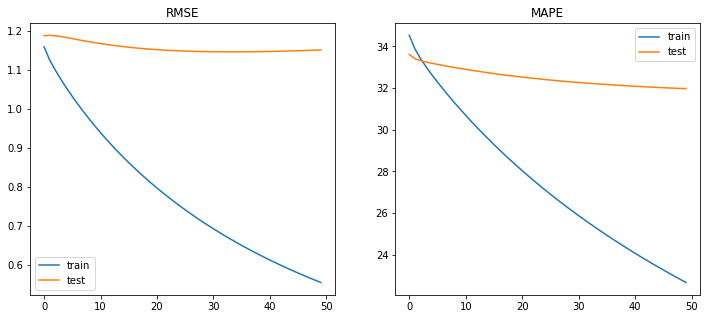

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_RMSE,label='train')
plt.plot(test_RMSE,label='test')
plt.title('RMSE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_MAPE,label='train')
plt.plot(test_MAPE,label='test')
plt.title('MAPE')
plt.legend()
plt.show()

##4.3. XGBOOST with 8 hand crafted features

In [ ]:
orders = pd.read_csv('orders.csv')

In [ ]:
#preparing dataframes
rated_orders = orders[['customer_id','LOCATION_NUMBER','vendor_id','vendor_rating']][~orders.vendor_rating.isna()]
rated_orders = rated_orders[rated_orders.vendor_rating!=0]
rated_orders['customer_id'] = rated_orders['customer_id']+'-'+rated_orders['LOCATION_NUMBER'].apply(str)
rated_orders = rated_orders.drop(['LOCATION_NUMBER'],axis=1)
rated_orders  = rated_orders.reset_index(drop=True)

#splitting in train and test
rated_orders_train, rated_orders_test = train_test_split(rated_orders,test_size=0.1,random_state=20)

rated_orders_train = pd.DataFrame(rated_orders_train.groupby(['customer_id','vendor_id'])['vendor_rating'].mean()).reset_index()
rated_orders_test = pd.DataFrame(rated_orders_test.groupby(['customer_id','vendor_id'])['vendor_rating'].mean()).reset_index()

#mapping table customers train
customer_id_index_train = np.unique(rated_orders_train.customer_id)
df_customer_id_index_train = pd.DataFrame(customer_id_index_train)
df_customer_id_index_train = df_customer_id_index_train.reset_index()
df_customer_id_index_train.rename(columns={'index':'customer_idx',0:'customer_id'}, inplace=True)

#mapping table vendors train
vendor_id_index_train = np.unique(rated_orders_train.vendor_id)
df_vendor_id_index_train = pd.DataFrame(vendor_id_index_train)
df_vendor_id_index_train = df_vendor_id_index_train.reset_index()
df_vendor_id_index_train.rename(columns={'index':'vendor_idx',0:'vendor_id'}, inplace=True)

#mapping table customers test
customer_id_index_test = np.unique(rated_orders_test.customer_id)
df_customer_id_index_test = pd.DataFrame(customer_id_index_test)
df_customer_id_index_test = df_customer_id_index_test.reset_index()
df_customer_id_index_test.rename(columns={'index':'customer_idx',0:'customer_id'}, inplace=True)

#mapping table vendors test
vendor_id_index_test = np.unique(rated_orders_test.vendor_id)
df_vendor_id_index_test = pd.DataFrame(vendor_id_index_test)
df_vendor_id_index_test = df_vendor_id_index_test.reset_index()
df_vendor_id_index_test.rename(columns={'index':'vendor_idx',0:'vendor_id'}, inplace=True)

#mapping vendors and customers in main train table
rated_orders_train = rated_orders_train.merge(df_vendor_id_index_train,on='vendor_id')
rated_orders_train = rated_orders_train.merge(df_customer_id_index_train,on='customer_id')
rated_orders_train = rated_orders_train.drop(['vendor_id','customer_id'],axis =1)
rated_orders_train = rated_orders_train[['customer_idx','vendor_idx','vendor_rating']]

#mapping vendors and customers in main test table
rated_orders_test = rated_orders_test.merge(df_vendor_id_index_test,on='vendor_id')
rated_orders_test = rated_orders_test.merge(df_customer_id_index_test,on='customer_id')
rated_orders_test = rated_orders_test.drop(['vendor_id','customer_id'],axis =1)
rated_orders_test = rated_orders_test[['customer_idx','vendor_idx','vendor_rating']]

global_rating = rated_orders_train.vendor_rating.mean()

In [ ]:
#creating pivot tables
z_rated_train = rated_orders_train.pivot_table(index='customer_idx',columns='vendor_idx',values = 'vendor_rating')
z_rated_test = rated_orders_test.pivot_table(index='customer_idx',columns='vendor_idx',values = 'vendor_rating')

In [ ]:
#making the column count of test dataset same as train dataset
for i in range(100):
  if i not in z_rated_test.columns:
    z_rated_test[i] = np.NaN 

In [ ]:
#making the row count of test dataset same as train dataset
for i in range(z_rated_train.shape[0]):
  if i not in z_rated_test.index:
     z_rated_test.loc[i] = np.NaN

In [ ]:
# creating sparse matrix
adjacency_matrix_train = csr_matrix(z_rated_train)
adjacency_matrix_test = csr_matrix(z_rated_test)

In [ ]:
adjacency_matrix_train.data = np.nan_to_num(adjacency_matrix_train.data, copy=False)
adjacency_matrix_test.data = np.nan_to_num(adjacency_matrix_test.data, copy=False)

<h1> Creating 8 Hand-Crafted features </h1>
Global avg, user avg,vendor avg, 3 similar user ratings rated same vendor,2 similar movies rated by user

In [ ]:
count = 0
for i  in tqdm(range(len(rated_orders_train))):
  customer = rated_orders_train.iloc[i,0]
  vendor = rated_orders_train.iloc[i,1]
  rating = rated_orders_train.iloc[i,2]
  #--------------------- Ratings of "vendor" by similar customers of "customer" ---------------------
  # compute the similar customers of the "customer" 
  customer_sim = cosine_similarity(adjacency_matrix_train[customer], adjacency_matrix_train).ravel()
  top_sim_customers = customer_sim.argsort()[::-1][1:4] # we are ignoring 'The customer' from its similar customers.
  # get the ratings of most similar customers for this vendor
  top_sim_customers_ratings = list(rated_orders_train[(rated_orders_train.customer_idx.isin(top_sim_customers))&(rated_orders_train.vendor_idx == vendor )]['vendor_rating'])
  while len(top_sim_customers_ratings) <3:
    top_sim_customers_ratings.append(global_rating)



  #--------------------- Ratings by "customer"  to similar vendors of "vendor" ---------------------
  # compute the similar vendors of the "vendor"        
  vendor_sim = cosine_similarity(adjacency_matrix_train[:,vendor].T, adjacency_matrix_train.T).ravel()
  top_sim_vendors = vendor_sim.argsort()[::-1][1:3] # we are ignoring 'The customer' from its similar customers.
  # get the ratings of most similar vendor rated by this customer..
  top_sim_vendors_ratings = list(rated_orders_train[(rated_orders_train.vendor_idx.isin(top_sim_vendors))&(rated_orders_train.customer_idx == customer )]['vendor_rating'])
  while len(top_sim_vendors_ratings) <2:
    top_sim_vendors_ratings.append(global_rating)
  

  #-----------------prepare the row to be stores in a file-----------------#
  row = list()
  row.append(df_customer_id_index_train[df_customer_id_index_train.customer_idx== customer]['customer_id'].values[0])
  
  row.append(df_vendor_id_index_train[df_vendor_id_index_train.vendor_idx== vendor]['vendor_id'].values[0])
  
  # Now add the other features to this data...
  row.append(global_rating) # first feature
  # next 5 features are similar_customers "vendor" ratings
  row.extend(top_sim_customers_ratings)
  
  # next 5 features are "customer" ratings for similar_vendors
  row.extend(top_sim_vendors_ratings)
  
  # Avg_customer rating
  row.append(np.mean(rated_orders_train[rated_orders_train.customer_idx == customer]['vendor_rating']))
  
  # Avg_vendor rating
  row.append(np.mean(rated_orders_train[rated_orders_train.vendor_idx == vendor]['vendor_rating']))
  
  # rating for customer-vendor combination
  row.append(rating)
  

  if count == 0:
    HC_train = pd.DataFrame(columns=['customer','vendor','GAvg','SU1','SU2','SU3','SV1','SV2','Cavg','Vavg','rating'])
  HC_train.loc[count] = row
  count+=1

  0%|          | 0/12901 [00:00<?, ?it/s]

In [ ]:
HC_train.to_csv('HC_train.csv',index=False)

In [ ]:
HC_train = pd.read_csv('HC_train.csv')

In [ ]:
X_HC_train = HC_train.iloc[:,2:-1]
y_HC_train = HC_train.iloc[:,-1]

In [ ]:
count = 0
for i  in tqdm(range(len(rated_orders_test))):
  customer = rated_orders_test.iloc[i,0]
  vendor = rated_orders_test.iloc[i,1]
  rating = rated_orders_test.iloc[i,2]
  #--------------------- Ratings of "vendor" by similar customers of "customer" ---------------------
  # compute the similar customers of the "customer" 
  customer_sim = cosine_similarity(adjacency_matrix_test[customer], adjacency_matrix_train).ravel()
  top_sim_customers = customer_sim.argsort()[::-1][1:4] # we are ignoring 'The customer' from its similar customers.
  # get the ratings of most similar customers for this vendor
  top_sim_customers_ratings = list(rated_orders_train[(rated_orders_train.customer_idx.isin(top_sim_customers))&(rated_orders_train.vendor_idx == vendor )]['vendor_rating'])
  while len(top_sim_customers_ratings) <3:
    top_sim_customers_ratings.append(global_rating)



  #--------------------- Ratings by "customer"  to similar vendors of "vendor" ---------------------
  # compute the similar vendors of the "vendor"        
  vendor_sim = cosine_similarity(adjacency_matrix_test[:,vendor].T, adjacency_matrix_train.T).ravel()
  top_sim_vendors = vendor_sim.argsort()[::-1][1:3] # we are ignoring 'The customer' from its similar customers.
  # get the ratings of most similar vendor rated by this customer..
  top_sim_vendors_ratings = list(rated_orders_train[(rated_orders_train.vendor_idx.isin(top_sim_vendors))&(rated_orders_train.customer_idx == customer )]['vendor_rating'])
  while len(top_sim_vendors_ratings) <2:
    top_sim_vendors_ratings.append(global_rating)
  

  #-----------------prepare the row to be stores in a file-----------------#
  row = list()
  row.append(df_customer_id_index_test[df_customer_id_index_test.customer_idx== customer]['customer_id'].values[0])
  
  row.append(df_vendor_id_index_test[df_vendor_id_index_test.vendor_idx== vendor]['vendor_id'].values[0])
  
  # Now add the other features to this data...
  row.append(global_rating) # first feature
  # next 5 features are similar_customers "vendor" ratings
  row.extend(top_sim_customers_ratings)
  
  # next 5 features are "customer" ratings for similar_vendors
  row.extend(top_sim_vendors_ratings)
  
  # Avg_customer rating
  row.append(np.mean(rated_orders_train[rated_orders_train.customer_idx == customer]['vendor_rating']))
  
  # Avg_vendor rating
  row.append(np.mean(rated_orders_train[rated_orders_train.vendor_idx == vendor]['vendor_rating']))
  
  # rating for customer-vendor combination
  row.append(rating)
  

  if count == 0:
    HC_test = pd.DataFrame(columns=['customer','vendor','GAvg','SU1','SU2','SU3','SV1','SV2','Cavg','Vavg','rating'])
  HC_test.loc[count] = row
  count+=1


HC_test.vendor = HC_test.vendor.apply(int)

  0%|          | 0/1889 [00:00<?, ?it/s]

In [ ]:
HC_test.to_csv('HC_test.csv',index=False)

In [ ]:
HC_test

customer  vendor      GAvg  SU1       SU2       SU3       SV1  \
0     00HWUU3-1     299  4.341514  5.0  3.000000  4.000000  4.341514   
1     14QQRTB-2     299  4.341514  5.0  3.000000  4.000000  4.341514   
2     1EMNPG4-0     299  4.341514  5.0  5.000000  4.341514  4.341514   
3     1EMNPG4-0      43  4.341514  5.0  4.341514  4.341514  5.000000   
4     2D2DDJM-0     299  4.341514  5.0  3.000000  4.000000  4.341514   
...         ...     ...       ...  ...       ...       ...       ...   
1884  DW8D2N6-2     303  4.341514  2.0  5.000000  5.000000  4.341514   
1885  H2XYKIJ-1      81  4.341514  5.0  5.000000  2.000000  2.000000   
1886  OL1EW1M-1      81  4.341514  5.0  5.000000  2.000000  2.000000   
1887  Q9HION2-0     196  4.341514  5.0  5.000000  5.000000  2.000000   
1888  TM2TSX5-1     196  4.341514  5.0  5.000000  5.000000  4.341514   

           SV2  Cavg      Vavg  rating  
0     4.341514   5.0  4.663309     5.0  
1     4.341514   4.0  4.663309     5.0  
2     4.341514   5.0  4.663309     5.0  
3     4.341514   5.0  4.301205     5.0  
4     4.341514   5.0  4.663309     5.0  
...        ...   ...       ...     ...  
1884  4.341514   3.0  4.409091     5.0  
1885  4.341514   3.0  3.970588     3.0  
1886  4.341514   2.0  3.970588     5.0  
1887  4.341514   2.0  4.291667     5.0  
1888  4.341514   5.0  4.291667     5.0  

[1889 rows x 11 columns]

In [ ]:
HC_test = pd.read_csv('HC_test.csv')

In [ ]:
X_HC_test = HC_test.iloc[:,2:-1]
y_HC_test = HC_test.iloc[:,-1]

In [ ]:
X_HC_train_1 = X_HC_train.iloc[:,1:]
X_HC_test_1 = X_HC_test.iloc[:,1:]

In [ ]:
XGB = XGBRegressor(silent=False, random_state=15)
params = {'n_estimators':[i for i in range(10,500,10)],
          'learning_rate': [0.0001,0.001,0.01,0.1,1,10,100],
          'max_depth':[3,9,11,15,20,35,50,70,100,130,150,170]
         }
random_cfl=GridSearchCV(XGB,param_grid=params,verbose=10,n_jobs=-1,cv=2)
random_cfl.fit(X_HC_train,y_HC_train, eval_metric = 'rmse')


Fitting 2 folds for each of 343 candidates, totalling 686 fits
[22:04:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2, estimator=XGBRegressor(random_state=15, silent=False),
             n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                           100],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250, 260, 270, 280, 290, 300, ...]},
             verbose=10)

In [ ]:
random_cfl.best_estimator_

XGBRegressor(n_estimators=120, random_state=15, silent=False)

In [ ]:
XGB1 = XGBRegressor(silent=False, random_state=15)#random_cfl.best_estimator_
XGB1.fit(X_HC_train_1,y_HC_train, eval_metric = 'rmse')

[05:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=15, silent=False)

In [ ]:
predict_y = XGB1.predict(X_HC_train_1)

In [ ]:
print(((np.sum((y_HC_train - predict_y)**2))/len(predict_y))**.5)
print(np.mean(np.abs((y_HC_train - predict_y)/predict_y))*100)

0.3906200539642037
5.907487844928343


In [ ]:
predict_y = XGB1.predict(X_HC_test_1)

In [ ]:
print(((np.sum((y_HC_test - predict_y)**2))/len(predict_y))**.5)
print(np.mean(np.abs((y_HC_test - predict_y)/predict_y))*100)

1.5174944036219005
35.91353631316697


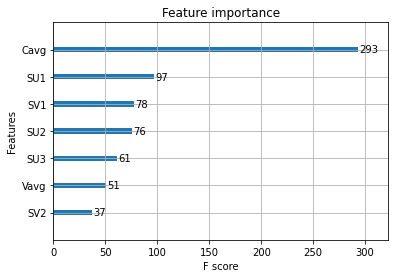

In [ ]:
import xgboost 
xgboost.plot_importance(XGB1)

##4.4. DL Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Activation, BatchNormalization,Dropout

In [ ]:
HC_test = pd.read_csv("HC_test.csv")
HC_train = pd.read_csv("HC_train.csv")

In [ ]:
vendors['distance'] = distance(vendors)

In [ ]:
#removing least popular categories
vendor_categories_modified = vendor_categories[vendor_categories.columns[ vendor_categories.sum()>=4]]
vendor_categories_modified['vendor'] = vendors['id']
vendor_categories_modified['vendor_distance'] = vendors['distance'] 

In [ ]:
train_customers

customer_id  gender  is_old  is_updated  distance  Other  Unknown  Work
0       TCHWPBT-0       1       1           0  0.640909      0        0     1
1       TCHWPBT-1       1       1           0  0.641857      0        0     0
2       TCHWPBT-2       1       1           0  0.526450      0        1     0
3       ZGFSYCZ-0       1       1           0  0.526408      0        0     0
4       ZGFSYCZ-1       1       1           0  0.526739      0        0     0
...           ...     ...     ...         ...       ...    ...      ...   ...
58208   JAI79PE-0       0       0           1  0.001070      0        1     0
58209   TR75VFL-0       0       0           1  0.002890      0        1     0
58210   SQMJ08H-0       0       0           1  0.002451      0        1     0
58211   9LW9CHN-0       0       0           1  0.002813      0        1     0
58212   LBMRK7A-0       0       0           1  0.125338      1        0     0

[58213 rows x 8 columns]

In [ ]:
HC_test = HC_test.rename({'customer':'customer_id'},axis=1)
HC_train = HC_train.rename({'customer':'customer_id'},axis=1)

In [ ]:
HC_test = HC_test.merge(vendor_categories_modified,on='vendor')
HC_test = HC_test.merge(train_customers,on='customer_id')

HC_train = HC_train.merge(vendor_categories_modified,on='vendor')
HC_train = HC_train.merge(train_customers,on='customer_id')

In [ ]:
HC_train.drop(['rating'],axis=1)

customer_id  vendor      GAvg  SU1       SU2       SU3       SV1  \
0       00OT8JX-3       4  4.341514  5.0  4.333333  4.341514  4.341514   
1       00OT8JX-3      75  4.341514  4.0  5.000000  4.341514  5.000000   
2       00OT8JX-3     188  4.341514  5.0  4.341514  4.341514  5.000000   
3       00OT8JX-3     298  4.341514  5.0  5.000000  4.341514  4.341514   
4       00OT8JX-3     841  4.341514  4.0  4.341514  4.341514  5.000000   
...           ...     ...       ...  ...       ...       ...       ...   
12578   AYPZ7WX-0     231  4.341514  5.0  5.000000  5.000000  4.341514   
12579   F2IOQF7-1     231  4.341514  5.0  5.000000  5.000000  4.341514   
12580   FOCSVSS-0     231  4.341514  5.0  5.000000  5.000000  4.341514   
12581   VST9J5B-0     231  4.341514  5.0  5.000000  5.000000  4.341514   
12582   WH9WF3W-0     231  4.341514  5.0  5.000000  5.000000  4.341514   

            SV2  Cavg      Vavg  ...  smoothies  cafe  vendor_distance  \
0      4.341514   5.0  4.264609  ...        0.0   0.0       106.432914   
1      4.341514   5.0  4.436966  ...        0.0   0.0       107.375516   
2      4.341514   5.0  4.603395  ...        0.0   0.0        84.696360   
3      4.341514   5.0  4.663309  ...        0.0   0.0        85.186304   
4      4.341514   5.0  4.173588  ...        0.0   1.0        99.117312   
...         ...   ...       ...  ...        ...   ...              ...   
12578  4.341514   5.0  4.300000  ...        0.0   0.0              NaN   
12579  4.341514   3.0  4.300000  ...        0.0   0.0              NaN   
12580  4.341514   5.0  4.300000  ...        0.0   0.0              NaN   
12581  4.341514   5.0  4.300000  ...        0.0   0.0              NaN   
12582  4.341514   3.0  4.300000  ...        0.0   0.0              NaN   

       gender  is_old  is_updated  distance  Other  Unknown  Work  
0           1       1           0  0.005306      0        1     0  
1           1       1           0  0.005306      0        1     0  
2           1       1           0  0.005306      0        1     0  
3           1       1           0  0.005306      0        1     0  
4           1       1           0  0.005306      0        1     0  
...       ...     ...         ...       ...    ...      ...   ...  
12578       1       1           0  0.526488      0        1     0  
12579       1       1           0  0.526584      0        0     1  
12580       1       1           0  0.006905      0        1     0  
12581       1       1           0  0.525685      1        0     0  
12582       1       1           0  0.526610      0        1     0  

[12583 rows x 51 columns]

In [ ]:
HC_train = HC_train.drop(['SU1','SU2','SU3','SV1','SV2'],axis = 1)
HC_test = HC_test.drop(['SU1','SU2','SU3','SV1','SV2'],axis = 1)

In [ ]:
X_HC_train = HC_train.drop(['rating'],axis=1)
y_HC_train = HC_train['rating']

X_HC_test = HC_test.drop(['rating'],axis=1)
y_HC_test = HC_test['rating']

In [ ]:
X_HC_train['Other'] = X_HC_train['Other'].apply(int)
X_HC_train['Unknown'] = X_HC_train['Unknown'].apply(int)
X_HC_train['Work'] = X_HC_train['Work'].apply(int)

X_HC_test['Other'] = X_HC_test['Other'].apply(int)
X_HC_test['Unknown'] = X_HC_test['Unknown'].apply(int)
X_HC_test['Work'] = X_HC_test['Work'].apply(int)

In [ ]:
max_dis_ven = np.max(X_HC_train['vendor_distance'])
min_dis_ven = np.min(X_HC_train['vendor_distance'])
X_HC_train['vendor_distance'] = (X_HC_train['vendor_distance'] - min_dis_ven)/(max_dis_ven - min_dis_ven)
X_HC_test['vendor_distance'] = (X_HC_test['vendor_distance'] - min_dis_ven)/(max_dis_ven - min_dis_ven)

In [ ]:
X_HC_train = X_HC_train.fillna(0)
X_HC_test = X_HC_test.fillna(0)

In [ ]:
X_train = np.array(X_HC_train.iloc[:,2:])
X_test = np.array(X_HC_test.iloc[:,2:])

y_train = np.zeros((len(y_HC_train),5)) 

y_train = np.array(y_HC_train)

y_test = np.zeros((len(y_HC_test),5)) 

y_test = np.array(y_HC_test)

In [ ]:
i1 = Input(shape=44)
R = Dense(2048)(i1)
R = Activation('linear')(R)
R = Dense(1024)(R)
R = Activation('linear')(R)
R = Dropout(0.5)(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(128)(R)
R = Activation('linear')(R)
R = Dropout(0.5)(R)
R= BatchNormalization()(R)

R = Dense(1)(R)

m1 = Model(inputs=i1,outputs=R)

In [ ]:
# Function of calculating RMSE
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def MAPE(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred)/y_true))*100
opt = tf.keras.optimizers.Adagrad(learning_rate=0.01)
m1.compile(optimizer=opt, loss=RMSE,  metrics=[RMSE,MAPE])

m1.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 44)]              0         
                                                                 
 dense_58 (Dense)            (None, 2048)              92160     
                                                                 
 activation_48 (Activation)  (None, 2048)              0         
                                                                 
 dense_59 (Dense)            (None, 1024)              2098176   
                                                                 
 activation_49 (Activation)  (None, 1024)              0         
                                                                 
 dropout_21 (Dropout)        (None, 1024)              0         
                                                                 
 dense_60 (Dense)            (None, 256)               262

In [ ]:
m1.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),epochs=50,
  batch_size=200)

Epoch 1/50
63/63 [==============================] - 8s 104ms/step - loss: 0.5595 - RMSE: 0.5595 - MAPE: 12.7148 - val_loss: 1.5226 - val_RMSE: 1.5276 - val_MAPE: 38.6788
Epoch 2/50
63/63 [==============================] - 5s 73ms/step - loss: 0.5563 - RMSE: 0.5562 - MAPE: 12.4411 - val_loss: 1.5267 - val_RMSE: 1.5310 - val_MAPE: 38.7109
Epoch 3/50
63/63 [==============================] - 5s 84ms/step - loss: 0.5530 - RMSE: 0.5529 - MAPE: 12.4517 - val_loss: 1.5464 - val_RMSE: 1.5509 - val_MAPE: 38.9626
Epoch 4/50
63/63 [==============================] - 5s 72ms/step - loss: 0.5551 - RMSE: 0.5551 - MAPE: 12.4666 - val_loss: 1.5351 - val_RMSE: 1.5397 - val_MAPE: 38.7487
Epoch 5/50
63/63 [==============================] - 5s 73ms/step - loss: 0.5533 - RMSE: 0.5532 - MAPE: 12.3969 - val_loss: 1.5377 - val_RMSE: 1.5418 - val_MAPE: 38.9571
Epoch 6/50
63/63 [==============================] - 5s 72ms/step - loss: 0.5542 - RMSE: 0.5541 - MAPE: 12.5064 - val_loss: 1.5393 - val_RMSE: 1.5438 - val

##4.5. Surprise models

###4.5.1. Surprise baseline model

In [ ]:
orders = pd.read_csv('orders.csv')

In [ ]:
#preparing dataframes
rated_orders = orders[['customer_id','LOCATION_NUMBER','vendor_id','vendor_rating']][~orders.vendor_rating.isna()]
rated_orders = rated_orders[rated_orders.vendor_rating!=0]
rated_orders['customer_id'] = rated_orders['customer_id']+'-'+rated_orders['LOCATION_NUMBER'].apply(str)
rated_orders = rated_orders.drop(['LOCATION_NUMBER'],axis=1)
rated_orders  = rated_orders.reset_index(drop=True)

#splitting in train and test
rated_orders_train, rated_orders_test = train_test_split(rated_orders,test_size=0.1,random_state=20)


In [ ]:
reader = Reader(rating_scale=(1,5))
train_data = Dataset.load_from_df(rated_orders_train,reader)
trainset = train_data.build_full_trainset() 


testset = list(zip(rated_orders_test.customer_id.values, rated_orders_test.vendor_id.values, rated_orders_test.vendor_rating.values))
testset[:3]

[('EF4HUHU-1', 858, 1.0), ('OADTTH6-3', 855, 5.0), ('K5LO5A5-0', 225, 2.0)]

In [ ]:

# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .1
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_algo.fit(trainset)
#bsl_train_results, bsl_test_results = run_surprise(bsl_algo, rated_orders_train, rated_orders_test, verbose=True)


# Just store these error metrics in our models_evaluation datastructure


Estimating biases using sgd...


In [ ]:

print('##################################### train #####################################')
train_preds = bsl_algo.test(trainset.build_testset())
print('RMSE:',str((np.sum(((pd.Series([list(i)[3] for i in train_preds]) - rated_orders_train.vendor_rating)**2)/len(rated_orders_train)))**.5))
print('MAPE:',str(np.mean(np.abs((pd.Series([list(i)[3] for i in train_preds]) - rated_orders_train.vendor_rating)/rated_orders_train.vendor_rating))*100))

print('##################################### test #####################################')
test_preds = bsl_algo.test(testset)
print('RMSE:',str((np.sum(((pd.Series([list(i)[3] for i in test_preds]) - rated_orders_test.vendor_rating)**2)/len(rated_orders_test)))**.5))
print('MAPE:',str(np.mean(np.abs((pd.Series([list(i)[3] for i in test_preds]) - rated_orders_test.vendor_rating)/rated_orders_test.vendor_rating))*100) )      

##################################### train #####################################
RMSE: 1.3022232692781897
MAPE: 35.9645884727922
##################################### test #####################################
RMSE: 0.37635636438774533
MAPE: 30.777503190430934


###4.5.2. Surprise KNNBASE

In [ ]:
orders = pd.read_csv('orders.csv')

In [ ]:
#preparing dataframes
rated_orders = orders[['customer_id','LOCATION_NUMBER','vendor_id','vendor_rating']][~orders.vendor_rating.isna()]
rated_orders = rated_orders[rated_orders.vendor_rating!=0]
rated_orders['customer_id'] = rated_orders['customer_id']+'-'+rated_orders['LOCATION_NUMBER'].apply(str)
rated_orders = rated_orders.drop(['LOCATION_NUMBER'],axis=1)
rated_orders  = rated_orders.reset_index(drop=True)

#splitting in train and test
rated_orders_train, rated_orders_test = train_test_split(rated_orders,test_size=0.1,random_state=20)

rated_orders_train = pd.DataFrame(rated_orders_train.groupby(['customer_id','vendor_id'])['vendor_rating'].mean()).reset_index()
rated_orders_test = pd.DataFrame(rated_orders_test.groupby(['customer_id','vendor_id'])['vendor_rating'].mean()).reset_index()

#mapping table customers train
customer_id_index_train = np.unique(rated_orders_train.customer_id)
df_customer_id_index_train = pd.DataFrame(customer_id_index_train)
df_customer_id_index_train = df_customer_id_index_train.reset_index()
df_customer_id_index_train.rename(columns={'index':'customer_idx',0:'customer_id'}, inplace=True)

#mapping table vendors train
vendor_id_index_train = np.unique(rated_orders_train.vendor_id)
df_vendor_id_index_train = pd.DataFrame(vendor_id_index_train)
df_vendor_id_index_train = df_vendor_id_index_train.reset_index()
df_vendor_id_index_train.rename(columns={'index':'vendor_idx',0:'vendor_id'}, inplace=True)

#mapping table customers test
customer_id_index_test = np.unique(rated_orders_test.customer_id)
df_customer_id_index_test = pd.DataFrame(customer_id_index_test)
df_customer_id_index_test = df_customer_id_index_test.reset_index()
df_customer_id_index_test.rename(columns={'index':'customer_idx',0:'customer_id'}, inplace=True)

#mapping table vendors test
vendor_id_index_test = np.unique(rated_orders_test.vendor_id)
df_vendor_id_index_test = pd.DataFrame(vendor_id_index_test)
df_vendor_id_index_test = df_vendor_id_index_test.reset_index()
df_vendor_id_index_test.rename(columns={'index':'vendor_idx',0:'vendor_id'}, inplace=True)

#mapping vendors and customers in main train table
rated_orders_train = rated_orders_train.merge(df_vendor_id_index_train,on='vendor_id')
rated_orders_train = rated_orders_train.merge(df_customer_id_index_train,on='customer_id')
rated_orders_train = rated_orders_train.drop(['vendor_id','customer_id'],axis =1)
rated_orders_train = rated_orders_train[['customer_idx','vendor_idx','vendor_rating']]

#mapping vendors and customers in main test table
rated_orders_test = rated_orders_test.merge(df_vendor_id_index_test,on='vendor_id')
rated_orders_test = rated_orders_test.merge(df_customer_id_index_test,on='customer_id')
rated_orders_test = rated_orders_test.drop(['vendor_id','customer_id'],axis =1)
rated_orders_test = rated_orders_test[['customer_idx','vendor_idx','vendor_rating']]

global_rating = rated_orders_train.vendor_rating.mean()

In [ ]:
train_data = Dataset.load_from_df(rated_orders_train,reader)
trainset = train_data.build_full_trainset() 


testset = list(zip(rated_orders_test.customer_idx.values, rated_orders_test.vendor_idx.values, rated_orders_test.vendor_rating.values))

In [ ]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : [True,False],
               'name': 'pearson_baseline',
               'shrinkage': [1,10,100],
               'min_support': [2,4,5],
                'k':[5,10,20,25]
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

#knn_bsl_u = KNNBaseline(k=[5,10,20,25], sim_options = sim_options, bsl_options = bsl_options)
gscv_model = GCVSurprise(KNNBaseline,param_grid=sim_options, cv=2)
gscv_model.fit(train_data)


Streaming output truncated to the last 5000 lines.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the

In [ ]:
knn_bsl = list(gscv_model.best_estimator.values())[0]

In [ ]:
knn_bsl.fit(trainset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:

print('##################################### train #####################################')
train_preds = knn_bsl.test(trainset.build_testset())
print((np.sum(((pd.Series([list(i)[3] for i in train_preds]) - rated_orders_train.vendor_rating)**2)/len(rated_orders_train)))**.5)
print(np.mean(np.abs((pd.Series([list(i)[3] for i in train_preds]) - rated_orders_train.vendor_rating)/rated_orders_train.vendor_rating))*100)

print('##################################### test #####################################')
test_preds = knn_bsl.test(testset)
print((np.sum(((pd.Series([list(i)[3] for i in test_preds]) - rated_orders_test.vendor_rating)**2)/len(rated_orders_test)))**.5)
print(np.mean(np.abs((pd.Series([list(i)[3] for i in test_preds]) - rated_orders_test.vendor_rating)/rated_orders_test.vendor_rating))*100)       

##################################### train #####################################
1.3510233595682726
35.98440442982335
##################################### test #####################################
0.38832056233050066
31.73200551297371


###4.5.3 Surprise SVD

In [ ]:
orders = pd.read_csv('orders.csv')

In [ ]:
#preparing dataframes
rated_orders = orders[['customer_id','LOCATION_NUMBER','vendor_id','vendor_rating']][~orders.vendor_rating.isna()]
rated_orders = rated_orders[rated_orders.vendor_rating!=0]
rated_orders['customer_id'] = rated_orders['customer_id']+'-'+rated_orders['LOCATION_NUMBER'].apply(str)
rated_orders = rated_orders.drop(['LOCATION_NUMBER'],axis=1)
rated_orders  = rated_orders.reset_index(drop=True)

#splitting in train and test
rated_orders_train, rated_orders_test = train_test_split(rated_orders,test_size=0.1,random_state=20)


In [ ]:
train_data = Dataset.load_from_df(rated_orders_train,reader)
trainset = train_data.build_full_trainset() 


testset = list(zip(rated_orders_test.customer_id.values, rated_orders_test.vendor_id.values, rated_orders_test.vendor_rating.values))

In [ ]:
# initiallize the model
parameters = {
    'n_factors':[1,2,5,10,20,30,40,50,60,80,100],
    'biased':[True,False]
}
gscv_model = GCVSurprise(SVD,param_grid=parameters, cv=2)
gscv_model.fit(train_data)


In [ ]:
svd = list(gscv_model.best_estimator.values())[0]
svd.fit(trainset)

In [ ]:
print('##################################### train #####################################')
train_preds = svd.test(trainset.build_testset())
print('RMSE:',str((np.sum(((pd.Series([list(i)[3] for i in train_preds]) - rated_orders_train.vendor_rating)**2)/len(rated_orders_train)))**.5))
print('MAPE:',str(np.mean(np.abs((pd.Series([list(i)[3] for i in train_preds]) - rated_orders_train.vendor_rating)/rated_orders_train.vendor_rating))*100))

print('##################################### test #####################################')
test_preds = svd.test(testset)
print('RMSE:',str((np.sum(((pd.Series([list(i)[3] for i in test_preds]) - rated_orders_test.vendor_rating)**2)/len(rated_orders_test)))**.5))
print('MAPE:',str(np.mean(np.abs((pd.Series([list(i)[3] for i in test_preds]) - rated_orders_test.vendor_rating)/rated_orders_test.vendor_rating))*100) )      

##################################### train #####################################
RMSE: 1.1038627317682836
MAPE: 34.437807108991706
##################################### test #####################################
RMSE: 0.3422725863282288
MAPE: 30.493268123711186


In [ ]:
import pickle

In [ ]:
pickle.dump(svd, open('Surprise_svd_model.pkl', 'wb'))

### 4.5.4. Surprise SVDpp

In [ ]:
orders = pd.read_csv('orders.csv')

In [ ]:
#preparing dataframes
rated_orders = orders[['customer_id','LOCATION_NUMBER','vendor_id','vendor_rating']][~orders.vendor_rating.isna()]
rated_orders = rated_orders[rated_orders.vendor_rating!=0]
rated_orders['customer_id'] = rated_orders['customer_id']+'-'+rated_orders['LOCATION_NUMBER'].apply(str)
rated_orders = rated_orders.drop(['LOCATION_NUMBER'],axis=1)
rated_orders  = rated_orders.reset_index(drop=True)

#splitting in train and test
rated_orders_train, rated_orders_test = train_test_split(rated_orders,test_size=0.1,random_state=20)


In [ ]:
train_data = Dataset.load_from_df(rated_orders_train,reader)
trainset = train_data.build_full_trainset() 


testset = list(zip(rated_orders_test.customer_id.values, rated_orders_test.vendor_id.values, rated_orders_test.vendor_rating.values))

In [ ]:
# initiallize the model
parameters = {
    'n_factors':[1,5,10,50,60,20,40,100]
}

gscv_model = GCVSurprise(SVDpp,param_grid=parameters, cv=2)
gscv_model.fit(train_data)

In [ ]:
svdpp = list(gscv_model.best_estimator.values())[0]
svdpp.fit(trainset)

In [ ]:

print('##################################### train #####################################')
train_preds = svdpp.test(trainset.build_testset())
print('RMSE:',str((np.sum(((pd.Series([list(i)[3] for i in train_preds]) - rated_orders_train.vendor_rating)**2)/len(rated_orders_train)))**.5))
print('MAPE:',str(np.mean(np.abs((pd.Series([list(i)[3] for i in train_preds]) - rated_orders_train.vendor_rating)/rated_orders_train.vendor_rating))*100))

print('##################################### test #####################################')
test_preds = svdpp.test(testset)
print('RMSE:',str((np.sum(((pd.Series([list(i)[3] for i in test_preds]) - rated_orders_test.vendor_rating)**2)/len(rated_orders_test)))**.5))
print('MAPE:',str(np.mean(np.abs((pd.Series([list(i)[3] for i in test_preds]) - rated_orders_test.vendor_rating)/rated_orders_test.vendor_rating))*100) )      

##################################### train #####################################
RMSE: 1.0951176982681372
MAPE: 34.44698543834768
##################################### test #####################################
RMSE: 0.3426427263686592
MAPE: 30.59979491690944


#5. Conclusion

Surprise SVD performs the best

Predicting all the combinations using SVD

In [ ]:
data = {'customer_id':[],'vendor_id':[],'rating':[]}
for i in tqdm(np.unique(rated_orders.customer_id)):
  for j in np.unique(rated_orders.vendor_id):
    data['customer_id'].append(i)
    data['vendor_id'].append(j)
    data['rating'].append(svd.predict(i,j)[3])

  0%|          | 0/9276 [00:00<?, ?it/s]

In [ ]:
predicted_values = pd.DataFrame(data)

In [ ]:
predicted_values.to_csv('predicted_svd.csv',index=False)

#6. USER - USER Similarity(CF)

<h3> Preparing test data for CF

In [ ]:
test_customers = pd.read_csv('test_customers.csv')
test_locations = pd.read_csv('test_locations.csv')

#preparing data
  max_distance = 17877.08408684324
  min_distance = 0.06398004160677155
test_customers = test_customers.drop(['dob','status','verified','language',],axis=1)
test_customers['is_old'] = (pd.to_datetime(test_customers['created_at'].apply(lambda x: x[:10]))<'2019-09-01').astype('int')
test_customers = test_customers.drop(['created_at'], axis=1)
test_customers['is_updated'] = (pd.to_datetime(test_customers['updated_at'].apply(lambda x: x[:10]))>='2019-11-01').astype('int')
test_customers = test_customers.drop(['updated_at'], axis=1)
test_customers.gender = test_customers.gender.apply(lambda x: 1 if str(x).strip().lower()[:4] == 'male' else 0)
#test_locations = test_locations.drop('location_type',axis=1)
test_locations.location_type = test_locations.location_type.fillna('Unknown')
test_customers = test_customers.rename({'akeed_customer_id':'customer_id'},axis=1)

# merging 2 tables
test_customers = test_customers.merge(test_locations,on='customer_id',)

#creating features
test_customers.customer_id = test_customers.customer_id + '-' + test_customers.location_number.apply(str)
test_customers['distance'] = distance(test_customers)
test_customers = test_customers.drop(['latitude','longitude'],axis=1)
#test_customers.distance = test_customers.distance.apply(lambda x: 0 if x<65 else (1 if x<111 else (2 if x <9407 else 3)))
# distance_df = pd.get_dummies(test_customers.distance,drop_first= True)
# c = []
# for i in distance_df.columns:
#     c.append('distance'+str(i))
# distance_df.columns = c
# test_customers = pd.concat([test_customers,distance_df],axis = 1)
# test_customers = test_customers.drop('distance',axis = 1)
test_customers.distance = (test_customers.distance - min_distance)/(max_distance-min_distance)
test_customers.distance = test_customers.distance.fillna(0) # removing the null distances
location_df = pd.get_dummies(test_customers.location_type,drop_first= True)
test_customers = pd.concat([test_customers,location_df],axis = 1)
test_customers = test_customers.drop('location_number',axis = 1)
test_customers = test_customers.drop('location_type',axis=1)
test_customers = test_customers.drop_duplicates(subset=['customer_id'])


test_customers

customer_id  gender  is_old  is_updated  distance  Other  Unknown  Work
0       ICE2DJP-0       1       1           0  0.640909      0        1     0
1       ICE2DJP-1       1       1           0  0.526601      0        1     0
2       ICE2DJP-2       1       1           0  0.648390      1        0     0
3       ICE2DJP-3       1       1           0  0.656770      1        0     0
4       ICE2DJP-4       1       1           0  0.000000      0        0     1
...           ...     ...     ...         ...       ...    ...      ...   ...
16328   369I4YD-0       0       0           1  0.004620      0        1     0
16329   VUOXW5K-0       0       0           1  0.007262      0        1     0
16330   H1S2T2Y-0       0       0           1  0.000658      0        0     1
16331   QGPCD5S-0       0       0           1  0.935260      0        1     0
16332   RMPE9Z1-0       0       0           1  0.008249      0        1     0

[16317 rows x 8 columns]

In [ ]:
test_customers.info()

Function for cosine similarity

In [ ]:
#ref - https://www.geeksforgeeks.org/how-to-calculate-cosine-similarity-in-python/
from numpy.linalg import norm
def cosine_sim(A,B):
  return np.dot(A,B)/(norm(A)*norm(B))

Taking the MF file for rating lookup

In [ ]:
related_customers_lookup_table = pd.read_csv('predicted_svd.csv')

In [ ]:
#keeping only those user who have given atleast 1 rating
train_customers_CF = train_customers[train_customers.customer_id.isin(related_customers_lookup_table.customer_id)]

In [ ]:
related_customers_lookup_table = related_customers_lookup_table[~related_customers_lookup_table.vendor_id.isna()]

In [ ]:
related_customers_lookup_table = related_customers_lookup_table.merge(train_customers,on='customer_id')

In [ ]:
vendor_categories = vendor_categories.reset_index().rename({'index':'vendor_id'},axis=1)

In [ ]:
related_customers_lookup_table.vendor_id = related_customers_lookup_table.vendor_id.astype(int)

In [ ]:
vendor_categories.vendor_id = vendors.id

In [ ]:
vendor_categories.to_csv('vendor_vategories.csv')

In [ ]:
related_customers_lookup_table = related_customers_lookup_table.merge(vendor_categories,on='vendor_id')

In [ ]:
train_customer_cf_existing = related_customers_lookup_table.drop(['vendor_id','rating'],axis = 1)

In [ ]:
agg_dic = {'gender':'mean','is_old':'mean','is_updated':'mean','distance':'mean','Other':'mean','Unknown':'mean','Work':'mean'}
for i in vendor_categories.columns[1:]:
  agg_dic[i] = 'sum'

In [ ]:
train_customer_cf_existing = train_customer_cf_existing.groupby('customer_id').agg(agg_dic)

In [ ]:
train_customer_cf_existing.to_csv('train_customer_cf_existing.csv')

### Defining Function  for giving recomendation



*   This function will take 1 (user - location) combination and no. of recomendation required for that user as input and will return a Table where it will provide target as 1 for the recommended vendors and 0 for other vendors. 
*   The shape of the output table will be (100,2). 

*   After taking input it will calculate the cosine similarities for all the reference customers with the target customer and will pick the top 5 users and their similerities. Then it will lookup in the rating table and take the ratings of the vendors for those n customers and multiply them with their similerities and that will be the predicted ratings for target customer. then it will pick top n vendors from that list and put 1 as target for them and 0 for other vendors





In [ ]:
vendors.id = vendors.id.astype(str)

In [ ]:
def recomended_vendors(customer_id,items):
  target_customer = test_customers[test_customers.customer_id == customer_id].iloc[:,1:].values
  customers = []
  similerities = []
  items = 0-items-1
  for i in range(len(train_customers_CF)):
    ref_customer = train_customers_CF.iloc[i,:].values
    customers.append(ref_customer[0])
    similerities.append(float(cosine_sim(target_customer,ref_customer[1:])))
  related_customers = []
  related_customers_similerities = []
  rank = np.argsort(similerities)[-1:5:-1]
  for i in rank:
    related_customers.append(customers[i])
    related_customers_similerities.append(similerities[i])
  ref_customers = pd.DataFrame({'customer_id':related_customers,'similerities':related_customers_similerities})
  ref_customers = ref_customers.merge(related_customers_lookup_table,on='customer_id')
  ref_customers.rating = ref_customers.rating*ref_customers.similerities
  recomended_vendors = pd.DataFrame(ref_customers.groupby('vendor_id')['rating'].mean()).reset_index()
  recomended_vendors = recomended_vendors.iloc[-1:items:-1,:]
  recomended_vendors['target'] = 1
  recomended_vendors.vendor_id = recomended_vendors.vendor_id.apply(int).apply(str)
  all_vendors = pd.DataFrame({'customer_id':[customer_id for i in range(100)],'vendor_id':np.unique(related_customers_lookup_table.vendor_id)})
  all_vendors.vendor_id = all_vendors.vendor_id.apply(int).apply(str)
  all_vendors = all_vendors.merge(recomended_vendors,on='vendor_id',how='left')
  all_vendors.target = all_vendors.target.fillna(0).apply(int)
  all_vendors['CID X LOC_NUM X VENDOR'] = all_vendors.customer_id.apply(lambda x: x.replace('-',' X ')) +' X '+all_vendors.vendor_id
  all_vendors = all_vendors.rename({'vendor_id':'id'},axis=1)
  all_vendors = all_vendors.merge(vendors[['id','vendor_tag_name']],on='id')
  all_vendors = all_vendors[['CID X LOC_NUM X VENDOR','target','vendor_tag_name']]


  return all_vendors

In [ ]:
a  =recomended_vendors('ICE2DJP-4',10)
a[a.target==1]

CID X LOC_NUM X VENDOR  target  \
90      ICE2DJP X 4 X 681       1   
91      ICE2DJP X 4 X 841       1   
92      ICE2DJP X 4 X 843       1   
93      ICE2DJP X 4 X 845       1   
94      ICE2DJP X 4 X 846       1   
95      ICE2DJP X 4 X 849       1   
96      ICE2DJP X 4 X 855       1   
97      ICE2DJP X 4 X 856       1   
98      ICE2DJP X 4 X 858       1   
99      ICE2DJP X 4 X 907       1   

                                      vendor_tag_name  
90                Biryani,Desserts,Indian,Kebabs,Rice  
91  American,Breakfast,Burgers,Cafe,Desserts,Free ...  
92  American,Breakfast,Burgers,Cafe,Desserts,Free ...  
93  American,Breakfast,Burgers,Cafe,Desserts,Free ...  
94  American,Breakfast,Burgers,Cafe,Desserts,Free ...  
95  American,Breakfast,Burgers,Cafe,Desserts,Free ...  
96  American,Burgers,Desserts,Free Delivery,Fries,...  
97  American,Breakfast,Burgers,Cafe,Desserts,Free ...  
98  American,Breakfast,Burgers,Cafe,Desserts,Free ...  
99                       Fatayers,Mojitos ,Sandwiches

In [ ]:
for i in tqdm(range(len(test_customers))):
  recomended_vendor = recomended_vendors(test_customers.iloc[i,0],5)
  if i == 0:
    target_df = recomended_vendor
  else:
    target_df = target_df.append(recomended_vendor)